<a href="https://colab.research.google.com/github/ArafatRohan93/PSSP_LSTM/blob/main/PSSP_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Dataset Download

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Kaggle API Upload ------Dont touch-----------
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"arafat93","key":"c248e60f0af40ea871dda0a87be41cb5"}'}

In [ ]:
# ------Dont touch-----------
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [ ]:
!kaggle datasets download -d alfrandom/protein-secondary-structure -p /content/drive/My\ Drive/Protein/Kaggle

protein-secondary-structure.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/drive/My\ Drive/Protein/Kaggle/protein-secondary-structure.zip -d /content/drive/My\ Drive/Protein/Kaggle/ 

Archive:  /content/drive/My Drive/Protein/Kaggle/protein-secondary-structure.zip
replace /content/drive/My Drive/Protein/Kaggle/2018-06-06-pdb-intersect-pisces.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Code

# Load Data
To show proof of concept only considering sequences shorter than 32 amino acids. Also experiments suggest to apply a sliding overlapping window of size 3 to the input seqeunces. In the sense of  NLP this artificially creates a corpus consisting of much more different words (>7000 different ngrams compared to 20 amino acids). There has been a lot of research in respresenting protein sequences as sentences of  biological words.

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns #visualisation
sns.set(color_codes=True)

df = pd.read_csv('/content/drive/My Drive/Protein/Kaggle/2018-06-06-ss.cleaned.csv').sort_values(by=['pdb_id','chain_code'])
print(len(df))
df.head()


393732


,pdb_id,chain_code,seq,sst8,sst3,len,has_nonstd_aa
124730,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHGGGHHHHHHHHHHHHHHHCGGGGGGCTT...,CCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCHHHHHHCCC...,154,False
138377,102L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,CCHHHHHHHHHCCEEEEEECTTSCEEEETTEEEESSSCTTTHHHHH...,CCHHHHHHHHHCCEEEEEECCCCCEEEECCEEEECCCCCCCHHHHH...,165,False
124731,102M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHGGGHHHHHHHHHHHHHHHCGGGGGGCTT...,CCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCHHHHHHCCC...,154,False
140434,103L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,CCHHHHHHHHHCCEEEEEECTTSCEEEETTEECCCCCCCCCHHHHH...,CCHHHHHHHHHCCEEEEEECCCCCEEEECCEECCCCCCCCCHHHHH...,167,False
124732,103M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHGGGHHHHHHHHHHHHHHHCGGGGGGCTT...,CCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCHHHHHHCCC...,154,False


# Exloratory Data Analysis

## Full Data Analysis

(393732, 7)


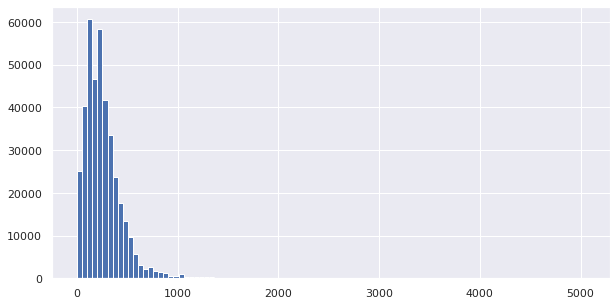

In [ ]:
df.len.hist(bins=100,figsize=[10,5],)
print(df.shape)

## Clear Asterisks

In [ ]:
def clear_asterisks(df, seqs_column_name, pct=0.00001):
    indices = []
    dropped = 0
    for i, seq in enumerate(df[seqs_column_name]):
        if (seq.count('*')*100/len(seq)) <= pct: indices.append(i)
        else:
          dropped = dropped+1
          print(seq)
    print(dropped)
    return df.iloc[indices]

df = clear_asterisks(df,'seq')
df.shape

Streaming output truncated to the last 5000 lines.
SSDPLVVAASIMGILHLILWILDRL*
SSDPLVVAASIMGILHLILWILDRL*
SSDPLVVAASIMGILHLILWILDRL*
CKGADGAHGV*GCPGTAGAAGSVGGPGCDGGHGGNGGNGNPGCAGGVGGAGGASGGTGVGGRGGKGGSGTPKGADGAPGAP
CKGADGAHGV*GCPGTAGAAGSVGGPGCDGGHGGNGGNGNPGCAGGVGGAGGASGGTGVGGRGGKGGSGTPKGADGAPGAP
*SLSAKDKANVKAIWGKILPKSDEIGEQALSRMLVVYPQTKAYFSHWASVAPGSAPVKKHGITIMNQIDDCVGHMDDLFGFLTKLSELHATKLRVDPTNFKILAHNLIVVIAAYFPAEFTPEIHLSVDKFLQQLALALAEKYR
*SLSAKDKANVKAIWGKILPKSDEIGEQALSRMLVVYPQTKAYFSHWASVAPGSAPVKKHGITIMNQIDDCVGHMDDLFGFLTKLSELHATKLRVDPTNFKILAHNLIVVIAAYFPAEFTPEIHLSVDKFLQQLALALAEKYR
*CRATKML
*LWQFNGMIKCKIPSSEPLLDFNNYGCYCGLGGSGTPVDDLDRCCQTHDNCYKQAKKLDSCKVLVDNPYTNNYSYSCSNNEITCSSENNACEAFICNCDRNAAICFSKVPYNKEHKNLDKKNC
*LLR
*LLR
MEELQDDYEDMMEEN*
R*PAF*
****************************
****************************
*RMKQIEDKLEEILSKLYH*ENE*ARIKKLL*ER
*RMKQIEDKLEEILSKLYH*ENE*ARIKKLL*ER
*RMKQIEDKLEEILSKLYH*ENE*ARIKKLL*ER
*RMKQIEDKLEEILSKLYH*ENE*ARIKKLL*ER
RMK*IEDKLEEI*SK*YH*ENELARIKKLL*ER
**MK*IEDKL*EI*SK*

(386333, 7)

## Select From Cleaned Data

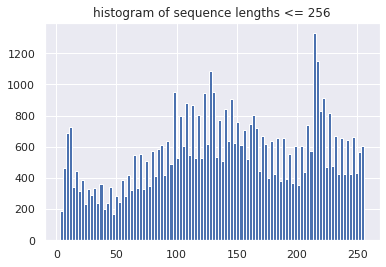

In [ ]:
df1 = df[['seq','len','sst3','sst8']][(df['len']<=256)&(df['has_nonstd_aa']==False)]
df1.drop_duplicates(subset='seq',inplace=True)
plt.hist(x='len',data=df1,bins=100,histtype='bar');
plt.title('histogram of sequence lengths <= 256');

## Q3 Structure count for  a given amino acid

dict_a:   {'C': 2958711, 'H': 3844017, 'E': 1307815}
dict_f:   {'C': 1364525, 'H': 1400272, 'E': 1190666}
dict_p:   {'C': 3450091, 'H': 834052, 'E': 429999}
dict_s:   {'C': 3549189, 'H': 1693692, 'E': 1151297}


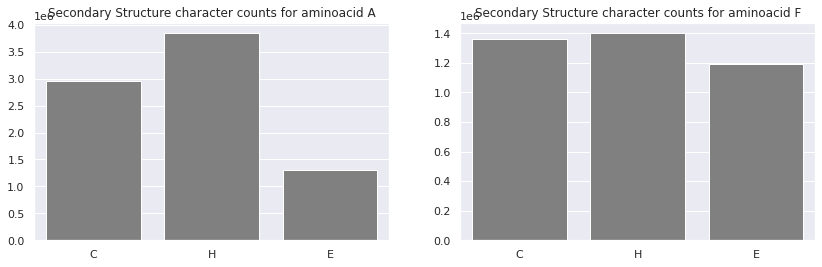

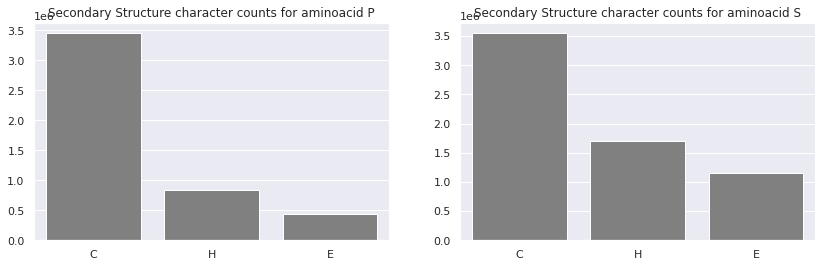

In [ ]:
dict_a = {'C':[],'H':[],'E':[]}
dict_f = {'C':[],'H':[],'E':[]}
dict_p = {'C':[],'H':[],'E':[]}
dict_s = {'C':[],'H':[],'E':[]}

for se,sst in zip(df['seq'],df['sst3']):
    for s,ss in zip(se,sst):
        if s == 'A':
            if ss == 'C': dict_a['C'].append(1)
            elif ss == 'H': dict_a['H'].append(1)
            elif ss == 'E': dict_a['E'].append(1)
        elif s == 'F':        
            if ss == 'C': dict_f['C'].append(1)
            elif ss == 'H': dict_f['H'].append(1)
            elif ss == 'E': dict_f['E'].append(1)
        elif s == 'P':        
            if ss == 'C': dict_p['C'].append(1)
            elif ss == 'H': dict_p['H'].append(1)
            elif ss == 'E': dict_p['E'].append(1)
        elif s == 'S':        
            if ss == 'C': dict_s['C'].append(1)
            elif ss == 'H': dict_s['H'].append(1)
            elif ss == 'E': dict_s['E'].append(1)
                
                
for k in dict_a.keys(): dict_a[k] = sum(dict_a[k])
for k in dict_f.keys(): dict_f[k] = sum(dict_f[k])
for k in dict_p.keys(): dict_p[k] = sum(dict_p[k])
for k in dict_s.keys(): dict_s[k] = sum(dict_s[k])
print('dict_a:  ',dict_a)
print('dict_f:  ',dict_f)
print('dict_p:  ',dict_p)
print('dict_s:  ',dict_s)


plt.figure(figsize=(14,4));
plt.subplot(1,2,1);
sns.barplot(x=list(dict_a.keys()),y=list(dict_a.values()),color='gray');
plt.title('Secondary Structure character counts for aminoacid A');
plt.subplot(1,2,2);
sns.barplot(x=list(dict_f.keys()),y=list(dict_f.values()),color='gray');
plt.title('Secondary Structure character counts for aminoacid F');
plt.figure(figsize=(14,4));
plt.subplot(1,2,1);
sns.barplot(x=list(dict_p.keys()),y=list(dict_p.values()),color='gray');
plt.title('Secondary Structure character counts for aminoacid P');
plt.subplot(1,2,2);
sns.barplot(x=list(dict_s.keys()),y=list(dict_s.values()),color='gray');
plt.title('Secondary Structure character counts for aminoacid S');

## Q8 Structure Count for a given amino acid

dict_a:   {'C': 1761874, 'E': 1251298, 'H': 3555768, 'B': 56517, 'G': 287048, 'I': 1201, 'T': 692613, 'S': 504224}
dict_f:   {'C': 791362, 'E': 1122680, 'H': 1249766, 'B': 67986, 'G': 149276, 'I': 1230, 'T': 297825, 'S': 275338}
dict_p:   {'C': 2213726, 'E': 379475, 'H': 605613, 'B': 50524, 'G': 227993, 'I': 446, 'T': 769222, 'S': 467143}
dict_s:   {'C': 2156131, 'E': 1079518, 'H': 1425388, 'B': 71779, 'G': 267397, 'I': 907, 'T': 723520, 'S': 669538}
dict_n:   {'C': 1266614, 'E': 519772, 'H': 972454, 'B': 49287, 'G': 159520, 'I': 698, 'T': 759951, 'S': 520902}
dict_q:   {'C': 915759, 'E': 600640, 'H': 1475081, 'B': 38058, 'G': 131551, 'I': 521, 'T': 373465, 'S': 296269}
dict_l:   {'C': 1754747, 'E': 2059303, 'H': 3836122, 'B': 108048, 'G': 289810, 'I': 2722, 'T': 590773, 'S': 489876}
dict_v:   {'C': 1416527, 'E': 2714794, 'H': 2098707, 'B': 109049, 'G': 109020, 'I': 1806, 'T': 302447, 'S': 362964}


Text(0.5, 1.0, 'Secondary Structure character counts for aminoacid V')

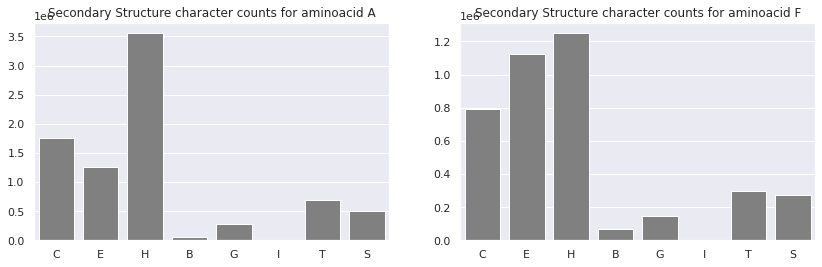

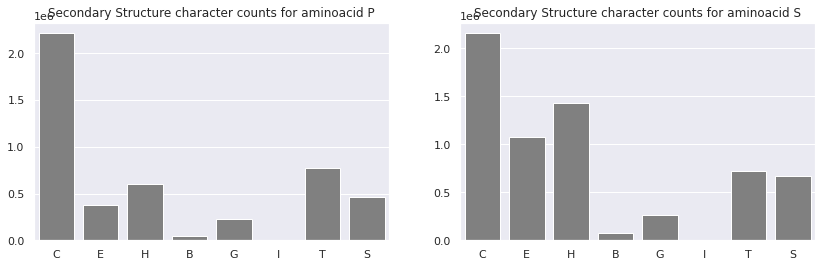

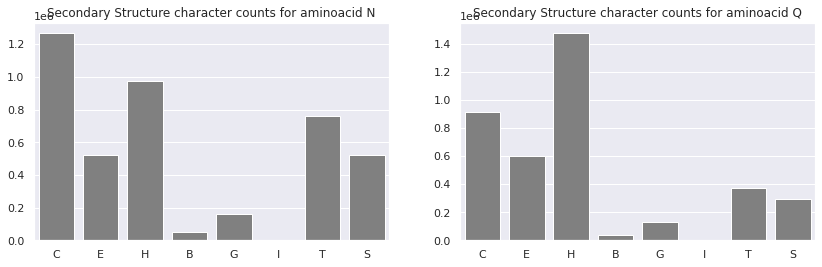

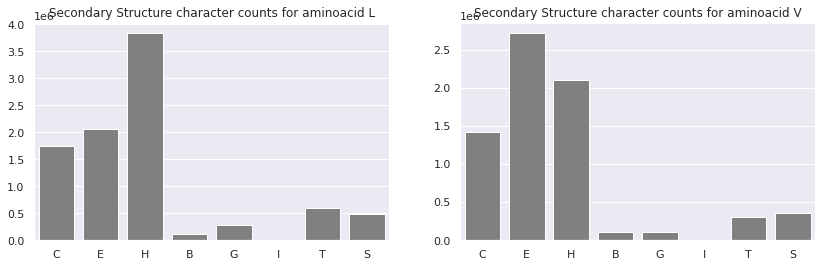

In [ ]:
dict_a = {'C':[],'E':[],'H':[],'B':[],'G':[],'I':[],'T':[],'S':[]}
dict_f = {'C':[],'E':[],'H':[],'B':[],'G':[],'I':[],'T':[],'S':[]}
dict_p = {'C':[],'E':[],'H':[],'B':[],'G':[],'I':[],'T':[],'S':[]}
dict_s = {'C':[],'E':[],'H':[],'B':[],'G':[],'I':[],'T':[],'S':[]}
dict_n = {'C':[],'E':[],'H':[],'B':[],'G':[],'I':[],'T':[],'S':[]}
dict_q = {'C':[],'E':[],'H':[],'B':[],'G':[],'I':[],'T':[],'S':[]}
dict_l = {'C':[],'E':[],'H':[],'B':[],'G':[],'I':[],'T':[],'S':[]}
dict_v = {'C':[],'E':[],'H':[],'B':[],'G':[],'I':[],'T':[],'S':[]}

for se,sst in zip(df['seq'],df['sst8']):
    for s,ss in zip(se,sst):
        if s == 'A':
            dict_a[ss].append(1)
        elif s == 'F':        
            dict_f[ss].append(1)
        elif s == 'P':        
            dict_p[ss].append(1)
        elif s == 'S':        
            dict_s[ss].append(1)
        elif s == 'N':        
            dict_n[ss].append(1)
        elif s == 'Q':        
            dict_q[ss].append(1)
        elif s == 'L':        
            dict_l[ss].append(1)
        elif s == 'V':        
            dict_v[ss].append(1)
                
for k in dict_a.keys(): dict_a[k] = sum(dict_a[k])
for k in dict_f.keys(): dict_f[k] = sum(dict_f[k])
for k in dict_p.keys(): dict_p[k] = sum(dict_p[k])
for k in dict_s.keys(): dict_s[k] = sum(dict_s[k])
for k in dict_n.keys(): dict_n[k] = sum(dict_n[k])
for k in dict_q.keys(): dict_q[k] = sum(dict_q[k])
for k in dict_l.keys(): dict_l[k] = sum(dict_l[k])
for k in dict_v.keys(): dict_v[k] = sum(dict_v[k])
print('dict_a:  ',dict_a)
print('dict_f:  ',dict_f)
print('dict_p:  ',dict_p)
print('dict_s:  ',dict_s)
print('dict_n:  ',dict_n)
print('dict_q:  ',dict_q)
print('dict_l:  ',dict_l)
print('dict_v:  ',dict_v)


plt.figure(figsize=(14,4));
plt.subplot(1,2,1);
sns.barplot(x=list(dict_a.keys()),y=list(dict_a.values()),color='gray');
plt.title('Secondary Structure character counts for aminoacid A');
plt.subplot(1,2,2);
sns.barplot(x=list(dict_f.keys()),y=list(dict_f.values()),color='gray');
plt.title('Secondary Structure character counts for aminoacid F');
plt.figure(figsize=(14,4));
plt.subplot(1,2,1);
sns.barplot(x=list(dict_p.keys()),y=list(dict_p.values()),color='gray');
plt.title('Secondary Structure character counts for aminoacid P');
plt.subplot(1,2,2);
sns.barplot(x=list(dict_s.keys()),y=list(dict_s.values()),color='gray');
plt.title('Secondary Structure character counts for aminoacid S');
plt.figure(figsize=(14,4));
plt.subplot(1,2,1);
sns.barplot(x=list(dict_n.keys()),y=list(dict_n.values()),color='gray');
plt.title('Secondary Structure character counts for aminoacid N');
plt.subplot(1,2,2);
sns.barplot(x=list(dict_q.keys()),y=list(dict_q.values()),color='gray');
plt.title('Secondary Structure character counts for aminoacid Q');
plt.figure(figsize=(14,4));
plt.subplot(1,2,1);
sns.barplot(x=list(dict_l.keys()),y=list(dict_l.values()),color='gray');
plt.title('Secondary Structure character counts for aminoacid L');
plt.subplot(1,2,2);
sns.barplot(x=list(dict_v.keys()),y=list(dict_v.values()),color='gray');
plt.title('Secondary Structure character counts for aminoacid V')

## Amino acid conunt for Each Q3 Structure

dict_c:   {'A': 2958711, 'R': 2198148, 'N': 2547467, 'D': 3329527, 'C': 552910, 'Q': 1585493, 'G': 5212271, 'E': 2695372, 'H': 1498590, 'I': 1546301, 'L': 2835396, 'K': 2721765, 'M': 936800, 'F': 1364525, 'P': 3450091, 'S': 3549189, 'T': 2715820, 'W': 441584, 'Y': 1209830, 'V': 2081938, '*': 0}
dict_h:   {'A': 3844017, 'R': 2093708, 'N': 1132672, 'D': 1714467, 'C': 400056, 'Q': 1607153, 'G': 1257731, 'E': 3062460, 'H': 742338, 'I': 2112918, 'L': 4128654, 'K': 2255832, 'M': 969599, 'F': 1400272, 'P': 834052, 'S': 1693692, 'T': 1489707, 'W': 531055, 'Y': 1189441, 'V': 2209533, '*': 0}
dict_e:   {'A': 1307815, 'R': 956131, 'N': 569059, 'D': 665040, 'C': 416318, 'Q': 638698, 'G': 1052559, 'E': 943221, 'H': 484611, 'I': 2026729, 'L': 2167351, 'K': 1003252, 'M': 472818, 'F': 1190666, 'P': 429999, 'S': 1151297, 'T': 1456465, 'W': 384234, 'Y': 1081356, 'V': 2823843, '*': 0}


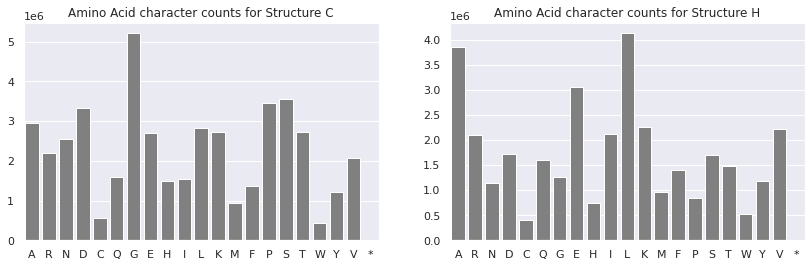

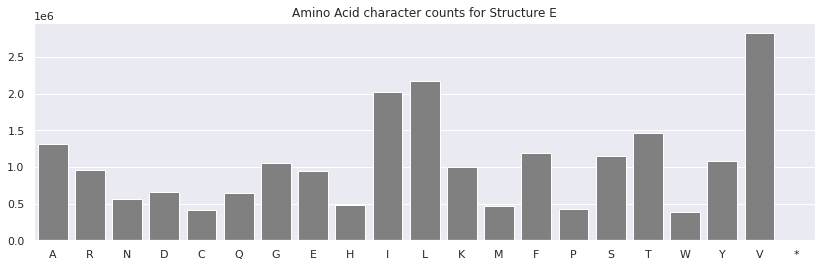

In [ ]:
dict_c = {'A':[],'R':[],'N':[],'D':[],'C':[],'Q':[],'G':[],'E':[],'H':[],'I':[],'L':[],'K':[],'M':[],'F':[],'P':[],'S':[],'T':[],'W':[],'Y':[],'V':[],'*':[]}
dict_h = {'A':[],'R':[],'N':[],'D':[],'C':[],'Q':[],'G':[],'E':[],'H':[],'I':[],'L':[],'K':[],'M':[],'F':[],'P':[],'S':[],'T':[],'W':[],'Y':[],'V':[],'*':[]}
dict_e = {'A':[],'R':[],'N':[],'D':[],'C':[],'Q':[],'G':[],'E':[],'H':[],'I':[],'L':[],'K':[],'M':[],'F':[],'P':[],'S':[],'T':[],'W':[],'Y':[],'V':[],'*':[]}

for se,sst in zip(df['seq'],df['sst3']):
    for s,ss in zip(se,sst):
        if ss == 'C':
            dict_c[s].append(1)
        elif ss == 'H':        
            dict_h[s].append(1)
        elif ss == 'E':        
            dict_e[s].append(1)
                
                
for k in dict_c.keys(): dict_c[k] = sum(dict_c[k])
for k in dict_h.keys(): dict_h[k] = sum(dict_h[k])
for k in dict_e.keys(): dict_e[k] = sum(dict_e[k])

print('dict_c:  ',dict_c)
print('dict_h:  ',dict_h)
print('dict_e:  ',dict_e)
# print('dict_s:  ',dict_s)


plt.figure(figsize=(14,4));
plt.subplot(1,2,1);
sns.barplot(x=list(dict_c.keys()),y=list(dict_c.values()),color='gray');
plt.title('Amino Acid character counts for Structure C');
plt.subplot(1,2,2);
sns.barplot(x=list(dict_h.keys()),y=list(dict_h.values()),color='gray');
plt.title('Amino Acid character counts for Structure H');
plt.figure(figsize=(14,4));
plt.subplot(1,1,1);
sns.barplot(x=list(dict_e.keys()),y=list(dict_e.values()),color='gray');
plt.title('Amino Acid character counts for Structure E');
# plt.subplot(1,2,2);
# sns.barplot(x=list(dict_s.keys()),y=list(dict_s.values()),color='gray');
# plt.title('Secondary Structure character counts for aminoacid S');

## Amino Acid Count for each Q8 

dict_c:   {'A': 1761874, 'R': 1240973, 'N': 1266614, 'D': 1814620, 'C': 350541, 'Q': 915759, 'G': 2121415, 'E': 1430037, 'H': 1000681, 'I': 1042929, 'L': 1754747, 'K': 1485904, 'M': 659760, 'F': 791362, 'P': 2213726, 'S': 2156131, 'T': 1682101, 'W': 243948, 'Y': 680227, 'V': 1416527, '*': 0}
dict_h:   {'A': 3555768, 'R': 1917500, 'N': 972454, 'D': 1447208, 'C': 359564, 'Q': 1475081, 'G': 1054163, 'E': 2770332, 'H': 644316, 'I': 2000289, 'L': 3836122, 'K': 2048139, 'M': 904032, 'F': 1249766, 'P': 605613, 'S': 1425388, 'T': 1355895, 'W': 460420, 'Y': 1060361, 'V': 2098707, '*': 0}
dict_e:   {'A': 1251298, 'R': 893586, 'N': 519772, 'D': 613466, 'C': 391551, 'Q': 600640, 'G': 988425, 'E': 900228, 'H': 452357, 'I': 1939162, 'L': 2059303, 'K': 945374, 'M': 446634, 'F': 1122680, 'P': 379475, 'S': 1079518, 'T': 1373572, 'W': 363082, 'Y': 1015996, 'V': 2714794, '*': 0}
dict_g:   {'A': 287048, 'R': 175253, 'N': 159520, 'D': 265920, 'C': 40108, 'Q': 131551, 'G': 201220, 'E': 290765, 'H': 97479, '

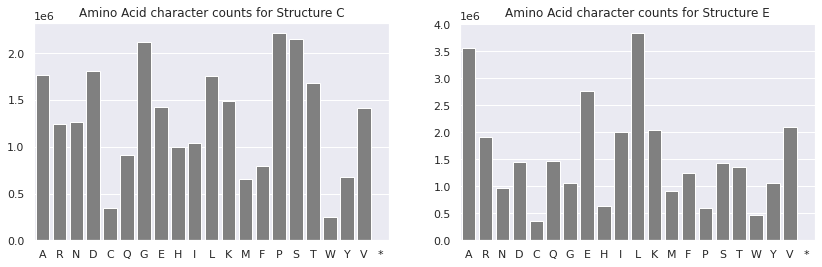

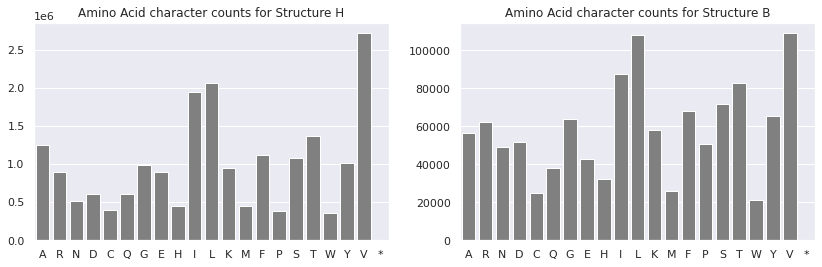

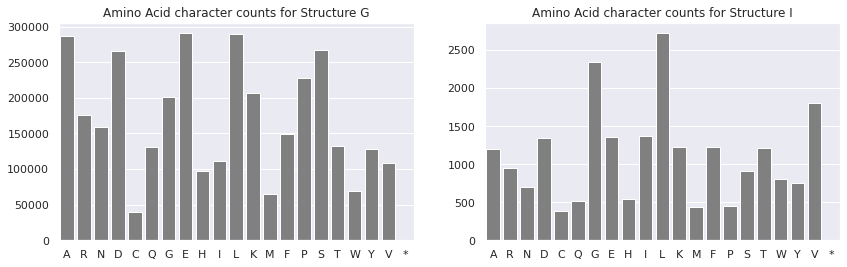

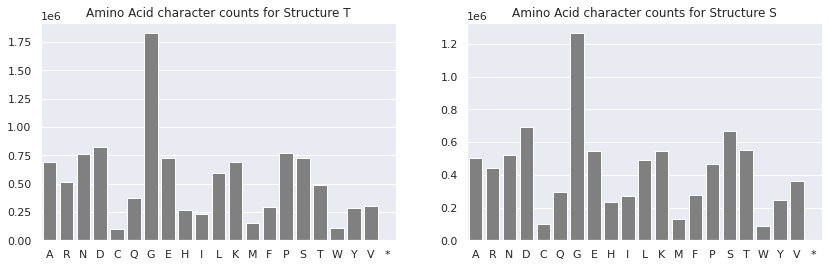

In [ ]:
from pandas.core.internals.construction import dict_to_mgr
dict_c = {'A':[],'R':[],'N':[],'D':[],'C':[],'Q':[],'G':[],'E':[],'H':[],'I':[],'L':[],'K':[],'M':[],'F':[],'P':[],'S':[],'T':[],'W':[],'Y':[],'V':[],'*':[]}
dict_e = {'A':[],'R':[],'N':[],'D':[],'C':[],'Q':[],'G':[],'E':[],'H':[],'I':[],'L':[],'K':[],'M':[],'F':[],'P':[],'S':[],'T':[],'W':[],'Y':[],'V':[],'*':[]}
dict_h = {'A':[],'R':[],'N':[],'D':[],'C':[],'Q':[],'G':[],'E':[],'H':[],'I':[],'L':[],'K':[],'M':[],'F':[],'P':[],'S':[],'T':[],'W':[],'Y':[],'V':[],'*':[]}
dict_b = {'A':[],'R':[],'N':[],'D':[],'C':[],'Q':[],'G':[],'E':[],'H':[],'I':[],'L':[],'K':[],'M':[],'F':[],'P':[],'S':[],'T':[],'W':[],'Y':[],'V':[],'*':[]}
dict_g = {'A':[],'R':[],'N':[],'D':[],'C':[],'Q':[],'G':[],'E':[],'H':[],'I':[],'L':[],'K':[],'M':[],'F':[],'P':[],'S':[],'T':[],'W':[],'Y':[],'V':[],'*':[]}
dict_i = {'A':[],'R':[],'N':[],'D':[],'C':[],'Q':[],'G':[],'E':[],'H':[],'I':[],'L':[],'K':[],'M':[],'F':[],'P':[],'S':[],'T':[],'W':[],'Y':[],'V':[],'*':[]}
dict_t = {'A':[],'R':[],'N':[],'D':[],'C':[],'Q':[],'G':[],'E':[],'H':[],'I':[],'L':[],'K':[],'M':[],'F':[],'P':[],'S':[],'T':[],'W':[],'Y':[],'V':[],'*':[]}
dict_s = {'A':[],'R':[],'N':[],'D':[],'C':[],'Q':[],'G':[],'E':[],'H':[],'I':[],'L':[],'K':[],'M':[],'F':[],'P':[],'S':[],'T':[],'W':[],'Y':[],'V':[],'*':[]}

for se,sst in zip(df['seq'],df['sst8']):
    for s,ss in zip(se,sst):
        if ss == 'C':
            dict_c[s].append(1)
        elif ss == 'H':        
            dict_h[s].append(1)
        elif ss == 'E':        
            dict_e[s].append(1)
        elif ss == 'B':        
            dict_b[s].append(1)
        elif ss == 'G':        
            dict_g[s].append(1)
        elif ss == 'I':        
            dict_i[s].append(1)
        elif ss == 'T':        
            dict_t[s].append(1)
        elif ss == 'S':        
            dict_s[s].append(1)
                
for k in dict_c.keys(): dict_c[k] = sum(dict_c[k])
for k in dict_h.keys(): dict_h[k] = sum(dict_h[k])
for k in dict_e.keys(): dict_e[k] = sum(dict_e[k])
for k in dict_g.keys(): dict_g[k] = sum(dict_g[k])
for k in dict_b.keys(): dict_b[k] = sum(dict_b[k])
for k in dict_i.keys(): dict_i[k] = sum(dict_i[k])
for k in dict_t.keys(): dict_t[k] = sum(dict_t[k])
for k in dict_s.keys(): dict_s[k] = sum(dict_s[k])

print('dict_c:  ',dict_c)
print('dict_h:  ',dict_h)
print('dict_e:  ',dict_e)
print('dict_g:  ',dict_g)
print('dict_b:  ',dict_b)
print('dict_i:  ',dict_i)
print('dict_t:  ',dict_t)
print('dict_s:  ',dict_s)


plt.figure(figsize=(14,4));
plt.subplot(1,2,1);
sns.barplot(x=list(dict_c.keys()),y=list(dict_c.values()),color='gray');
plt.title('Amino Acid character counts for Structure C');
plt.subplot(1,2,2);
sns.barplot(x=list(dict_e.keys()),y=list(dict_h.values()),color='gray');
plt.title('Amino Acid character counts for Structure E');
plt.figure(figsize=(14,4));
plt.subplot(1,2,1);
sns.barplot(x=list(dict_h.keys()),y=list(dict_e.values()),color='gray');
plt.title('Amino Acid character counts for Structure H');
plt.subplot(1,2,2);
sns.barplot(x=list(dict_b.keys()),y=list(dict_b.values()),color='gray');
plt.title('Amino Acid character counts for Structure B');
plt.figure(figsize=(14,4));
plt.subplot(1,2,1);
sns.barplot(x=list(dict_g.keys()),y=list(dict_g.values()),color='gray');
plt.title('Amino Acid character counts for Structure G');
plt.subplot(1,2,2);
sns.barplot(x=list(dict_i.keys()),y=list(dict_i.values()),color='gray');
plt.title('Amino Acid character counts for Structure I');
plt.figure(figsize=(14,4));
plt.subplot(1,2,1);
sns.barplot(x=list(dict_t.keys()),y=list(dict_t.values()),color='gray');
plt.title('Amino Acid character counts for Structure T');
plt.subplot(1,2,2);
sns.barplot(x=list(dict_s.keys()),y=list(dict_s.values()),color='gray');
plt.title('Amino Acid character counts for Structure S');

# Q3

In [ ]:
def seq2ngrams(seqs, n=3):
    return np.array([[seq[i:i+n] for i in range(len(seq))] for seq in seqs])

In [ ]:
maxlen_seq = 256
input_seqs, target_seqs = df[['seq', 'sst3']][(df.len <= maxlen_seq) & (~df.has_nonstd_aa)].values.T
input_grams = seq2ngrams(input_seqs)
print(input_grams[0])
print(input_seqs[0])
print(target_seqs[0])
print(len(input_seqs))
print(len(target_seqs))

['MVL', 'VLS', 'LSE', 'SEG', 'EGE', 'GEW', 'EWQ', 'WQL', 'QLV', 'LVL', 'VLH', 'LHV', 'HVW', 'VWA', 'WAK', 'AKV', 'KVE', 'VEA', 'EAD', 'ADV', 'DVA', 'VAG', 'AGH', 'GHG', 'HGQ', 'GQD', 'QDI', 'DIL', 'ILI', 'LIR', 'IRL', 'RLF', 'LFK', 'FKS', 'KSH', 'SHP', 'HPE', 'PET', 'ETL', 'TLE', 'LEK', 'EKF', 'KFD', 'FDR', 'DRV', 'RVK', 'VKH', 'KHL', 'HLK', 'LKT', 'KTE', 'TEA', 'EAE', 'AEM', 'EMK', 'MKA', 'KAS', 'ASE', 'SED', 'EDL', 'DLK', 'LKK', 'KKH', 'KHG', 'HGV', 'GVT', 'VTV', 'TVL', 'VLT', 'LTA', 'TAL', 'ALG', 'LGA', 'GAI', 'AIL', 'ILK', 'LKK', 'KKK', 'KKG', 'KGH', 'GHH', 'HHE', 'HEA', 'EAE', 'AEL', 'ELK', 'LKP', 'KPL', 'PLA', 'LAQ', 'AQS', 'QSH', 'SHA', 'HAT', 'ATK', 'TKH', 'KHK', 'HKI', 'KIP', 'IPI', 'PIK', 'IKY', 'KYL', 'YLE', 'LEF', 'EFI', 'FIS', 'ISE', 'SEA', 'EAI', 'AII', 'IIH', 'IHV', 'HVL', 'VLH', 'LHS', 'HSR', 'SRH', 'RHP', 'HPG', 'PGN', 'GNF', 'NFG', 'FGA', 'GAD', 'ADA', 'DAQ', 'AQG', 'QGA', 'GAM', 'AMN', 'MNK', 'NKA', 'KAL', 'ALE', 'LEL', 'ELF', 'LFR', 'FRK', 'RKD', 'KDI', 'DIA', 'IAA'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


## Preprocessing
use preprocessing tools for text from keras to encode input sequence as word rank numbers  and target sequence as one hot. To ensure easy to use training and testing, all sequences are padded with zeros to the maximum sequence length (in our case 32).

In [ ]:
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
# print("input_data[0]")
tokenizer_encoder = Tokenizer()
tokenizer_encoder.fit_on_texts(input_grams)
input_data = tokenizer_encoder.texts_to_sequences(input_grams)
# print(input_data[0])
input_data = sequence.pad_sequences(input_data, maxlen=maxlen_seq, padding='post')
# print(input_data[0])

# print("target_data[0]")
tokenizer_decoder = Tokenizer(char_level=True)
tokenizer_decoder.fit_on_texts(target_seqs)
target_data = tokenizer_decoder.texts_to_sequences(target_seqs)
# print(target_data[0])
target_data = sequence.pad_sequences(target_data, maxlen=maxlen_seq, padding='post')
# print(target_data[0])
target_data = to_categorical(target_data)
# print(target_data[0])
input_data.shape, target_data.shape

((226733, 256), (226733, 256, 4))

## Q3 Accuracy Function

In [ ]:
def q3_acc(y_true, y_pred):
    y = tf.argmax(y_true, axis=-1)
    y_ = tf.argmax(y_pred, axis=-1)
    mask = tf.greater(y, 0)
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
from keras.metrics import categorical_accuracy
from keras import backend  as K
import tensorflow as tf
import keras

n_words = len(tokenizer_encoder.word_index) + 1
n_tags = len(tokenizer_decoder.word_index) + 1
print(n_words, n_tags)

X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=.4, random_state=0)
seq_train, seq_test, target_train, target_test = train_test_split(input_seqs, target_seqs, test_size=.4, random_state=0)

8421 4


## LSTM

In [ ]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_words, output_dim=128, input_length=maxlen_seq),
    tf.keras.layers.LSTM(64,return_sequences=True, recurrent_dropout=0.1),
    tf.keras.layers.Dense(n_tags, activation='softmax'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 256, 128)          1077888   
                                                                 
 lstm_3 (LSTM)               (None, 256, 64)           49408     
                                                                 
 dense_3 (Dense)             (None, 256, 4)            260       
                                                                 
Total params: 1,127,556
Trainable params: 1,127,556
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy", q3_acc,keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(X_train, y_train, batch_size=256, epochs=10, validation_data=(X_test, y_test), verbose=1)
model.save("/content/drive/MyDrive/Protein/Models/LSTMmodel.h5")

Epoch 1/10
532/532 [==============================] - 691s 1s/step - loss: 0.4291 - accuracy: 0.8184 - q3_acc: 0.6883 - precision_4: 0.8716 - recall_4: 0.7569 - val_loss: 0.3591 - val_accuracy: 0.8521 - val_q3_acc: 0.7447 - val_precision_4: 0.8851 - val_recall_4: 0.8147
Epoch 2/10
532/532 [==============================] - 683s 1s/step - loss: 0.3320 - accuracy: 0.8623 - q3_acc: 0.7618 - precision_4: 0.8867 - recall_4: 0.8365 - val_loss: 0.3138 - val_accuracy: 0.8707 - val_q3_acc: 0.7769 - val_precision_4: 0.8892 - val_recall_4: 0.8522
Epoch 3/10
532/532 [==============================] - 686s 1s/step - loss: 0.2960 - accuracy: 0.8779 - q3_acc: 0.7888 - precision_4: 0.8978 - recall_4: 0.8573 - val_loss: 0.2878 - val_accuracy: 0.8813 - val_q3_acc: 0.7951 - val_precision_4: 0.9009 - val_recall_4: 0.8615
Epoch 4/10
532/532 [==============================] - 690s 1s/step - loss: 0.2715 - accuracy: 0.8887 - q3_acc: 0.8076 - precision_4: 0.9052 - recall_4: 0.8720 - val_loss: 0.2652 - val_acc

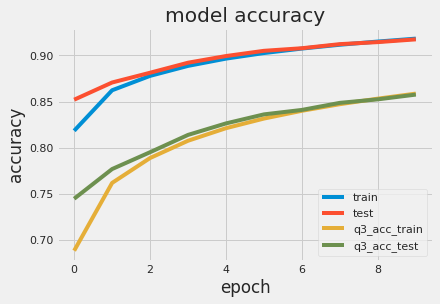

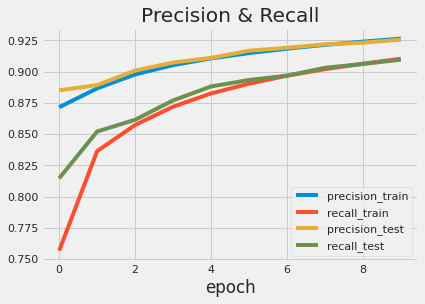

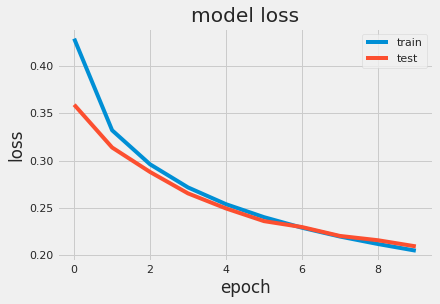

In [ ]:
hist = history.history

metrics = list()
for i in hist.keys():
    metrics.append(i)


# summarize history for accuracy
plt.plot(history.history[metrics[1]])
plt.plot(history.history[metrics[6]])
plt.plot(history.history[metrics[2]])
plt.plot(history.history[metrics[7]])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test','q3_acc_train','q3_acc_test'], loc='best')
plt.show()
# summarize history for precision and recall
plt.plot(history.history[metrics[3]])
plt.plot(history.history[metrics[4]])
plt.plot(history.history[metrics[8]])
plt.plot(history.history[metrics[9]])
plt.title('Precision & Recall')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['precision_train', 'recall_train','precision_test','recall_test'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history.history[metrics[0]])
plt.plot(history.history[metrics[5]])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], )
plt.show()

training
---
Input: MTITPSLKGFFIGLLSGAVVLGLTFAVLIAISQIDKVQRSL
Target: CCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCCCCCC
Result: CCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCCCCC


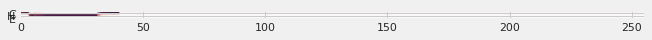

---
Input: MSKQPDKQRKSQRRAPLHERHKQVRATLSADLREEYGQRNVRVNAGDTVEVLRGDFAGEEGEVINVDLDKAVIHVEDVTLEKTDGEEVPRPLDTSNVRVTDLDLEDEKREARLESEDDSA
Target: CCCCHHHHHHHHHCCCHHHHHHHHEEEECHHHHHHHCCCEEECCCCCEEEECCCCCCCCEEEEEEEECCCCEEEECCCEEECCCCCEEECCECHHHEEEEECCCCCHHHHHHHHCCCCCC
Result: CCCCHHHHHHHHHCCCHHHHHHHHEEEECHHHHHHHCCCEEECCCCCEEEECCCCCCCCEEEEEEEECCCCEEEECCCEEECCCCCEEECCECHHHEEEEECCCCCHHHHHHHHCCCCCC


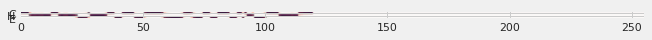

---
Input: KNHPMLMNLLKDN
Target: CCCHHHHHHCCCC
Result: CCCHHHHHHHCCC


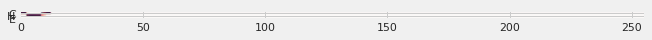

testing
---
Input: DLVNLLRCQEGPRNCRELLSQGATLSGWYHLCLPEGRALPVFCDMDTEGGGWLVFQRRQDGSVDFFRSWSSYRAGFGNQESEFWLGNENLHQLTLQGNWELRVELEDFNGNRTFAHYATFRLLGEVDHYQLALGKFSEGTAGDSLSLHSGRPFTTYDADHDSSNSNCAVIVHGAWWYASCYRSNLNGRYAVSEAAAHKYGIDWASGRGVGHPYRRVRMMLR
Target: CCCCCCCCCCCCCCHHHHHHCCCCCEEEEEEECCCCCEEEEEEECCHHHCCEEEEEEECCCCCCCCCCHHHHHHCEEECCCCEECCHHHHHHHHCCCCCCEEEEEECCCCCEEEEEECCEEECCHHHCCCEEECCECCCCCCCCCHHHCCCCCEECCECCCCCCCCHHHHCCCCECCCCCCCECCCCCCCCCCCCCCCCCCCECCCCCCCCCCCEEEEEEC
Result: CCCHHCCCCCCCCCHHHHHHHCCCCEEEECCCCCCCCCCCEEEEECCCCCCEEEEEEECCCCCEEEHCHHHHCCCCCCCCCHEECCCCCCHCEEECECEEEEEEEEEECCCEEEEEEEEEEHCCCCCHEHEEEEECCCCCCCCCEECCCCCCCCEHCCCCCCCCCCEEEEEEEEECCCCCCCCCCCCCEEEECCCCCCCCCCCCCCCCCCCCCCEEEEEEC


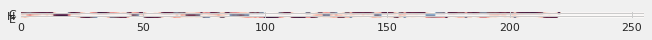

---
Input: MRIYSRLFQISSANYARQIMSNQFIKAKESKGLTYQQMAQLLSVNKVWLTSVLHGQNCCDIQLAHRICDTLGISHEYANELTSIPLRGNQNIINDPLIYRFNELFKVYGSSLRGIIHEEFGDGIMSAIDCKIDVTKNEQSRVILRIDGKFLPYYKGQLDAGENLYFQSAGHHHHHH
Target: CCCCCCCCCCCCCCCCCCCCCCHHHHHHHHHCCCHHHHHHHHCCCHHHHHHHHCCCCCCCHHHHHHHHHHCCCCHHHHHHHHCCCCCCCCCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHCCEEEEEEEEEEEEEECCCCEEEEEEEEEEEECCCCECCCCCCCCCCCCCCCCCCC
Result: CCEECCCCCCCCCCCCCCCCCHHHHHHHHHCCCCHHHHHHHHHHHHHHHHHHHCCCCCCCCHHHHHHHHHHCCCHHHHHHHHCCCCCCCCCCCCCCHHHHHHHHHHHHHHHHHHHHHHHHCCCCECEEEEEEECCCCCCCEEEEEECCEECCEECCEECCCCCCCCCCCCCCCCCC


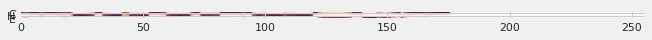

---
Input: AAPPPINKLALFPDKSAWCEAKNITQIVGHSGCEAKSIQNRACLGQCFSYSVPNTFPQSTESLVHCDSCMPAQSMWEIVTLECPGHEEVPRVDKLVEKILHCSCQACGKEPSHEGL
Target: CCCCCCCCCCCCCCCCCEEEEEEEEEEECCCCCCCEEEEEEEEEEEEEEEECCCCCCCCCCCCEEEEEEEEEEEEEEEEEEECCCCCCCCEEEEEEEEEEEEEEEECCCCCCCCCC
Result: CCCCCCCCCCCCCCCCCECCCCEEEEEECCCCEEEEEEECEEEEEEEEEEECCCCCCCCCHHHEEECECEEEEEEEEEEEEEEECCCCCCCCCEEEEHHEECCCCCCCCCCCCCCC


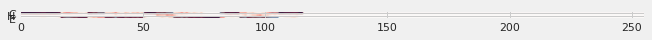

In [ ]:
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

def plot_results(x, y, y_):
    print("---")
    print("Input: " + str(x))
    print("Target: " + str(onehot_to_seq(y, revsere_decoder_index).upper()))
    print("Result: " + str(onehot_to_seq(y_, revsere_decoder_index).upper()))
    fig = plt.figure(figsize=(10,2))
    plt.imshow(y.T, cmap='Blues')
    plt.imshow(y_.T, cmap='Reds', alpha=.5)
    plt.yticks(range(4), [' '] + [revsere_decoder_index[i+1].upper() for i in range(3)])
    plt.show()
    
revsere_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()}
revsere_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()}

N=3
y_train_pred = model.predict(X_train[:N])
y_test_pred = model.predict(X_test[:N])
print('training')
for i in range(N):
    plot_results(seq_train[i], y_train[i], y_train_pred[i])
print('testing')
for i in range(N):
    plot_results(seq_test[i], y_test[i], y_test_pred[i])

## BiLSTM Model (Best One)

In [ ]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional

n_words = len(tokenizer_encoder.word_index) + 1
n_tags = len(tokenizer_decoder.word_index) + 1
print(n_words, n_tags)

input = Input(shape=(maxlen_seq,))
x = Embedding(input_dim=n_words, output_dim=128, input_length=maxlen_seq)(input)
x = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.1))(x)
y = TimeDistributed(Dense(n_tags, activation="softmax"))(x)
model = Model(input, y)
model.summary()

8421 4
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 256, 128)          1077888   
                                                                 
 bidirectional (Bidirectiona  (None, 256, 128)         98816     
 l)                                                              
                                                                 
 time_distributed_1 (TimeDis  (None, 256, 4)           516       
 tributed)                                                       
                                                                 
Total params: 1,177,220
Trainable params: 1,177,220
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.model_selection import train_test_split
from keras.metrics import categorical_accuracy
from keras import backend  as K
import tensorflow as tf
import keras

def q3_acc(y_true, y_pred):
    y = tf.argmax(y_true, axis=-1)
    y_ = tf.argmax(y_pred, axis=-1)
    mask = tf.greater(y, 0)
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy", q3_acc,keras.metrics.Precision(), keras.metrics.Recall()])

X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=.3, random_state=0)
seq_train, seq_test, target_train, target_test = train_test_split(input_seqs, target_seqs, test_size=.3, random_state=0)

model.fit(X_train, y_train, batch_size=256, epochs=10, validation_data=(X_test, y_test), verbose=1)
model.save("/content/drive/MyDrive/Protein/Models/BiLSTMmodel.h5")

Epoch 1/10
620/620 [==============================] - 1489s 2s/step - loss: 0.3783 - accuracy: 0.8412 - q3_acc: 0.7268 - precision_2: 0.8826 - recall_2: 0.7972 - val_loss: 0.3008 - val_accuracy: 0.8787 - val_q3_acc: 0.7906 - val_precision_2: 0.8940 - val_recall_2: 0.8625
Epoch 2/10
620/620 [==============================] - 1469s 2s/step - loss: 0.2807 - accuracy: 0.8871 - q3_acc: 0.8049 - precision_2: 0.9011 - recall_2: 0.8726 - val_loss: 0.2598 - val_accuracy: 0.8963 - val_q3_acc: 0.8209 - val_precision_2: 0.9099 - val_recall_2: 0.8822
Epoch 3/10
620/620 [==============================] - 1510s 2s/step - loss: 0.2462 - accuracy: 0.9016 - q3_acc: 0.8300 - precision_2: 0.9125 - recall_2: 0.8905 - val_loss: 0.2325 - val_accuracy: 0.9081 - val_q3_acc: 0.8414 - val_precision_2: 0.9174 - val_recall_2: 0.8986
Epoch 4/10
620/620 [==============================] - 1481s 2s/step - loss: 0.2236 - accuracy: 0.9113 - q3_acc: 0.8467 - precision_2: 0.9201 - recall_2: 0.9023 - val_loss: 0.2157 - val

In [ ]:
hist = history.history

metrics = list()
for i in hist.keys():
    metrics.append(i)


['loss',
 'accuracy',
 'q3_acc',
 'precision_1',
 'recall_1',
 'val_loss',
 'val_accuracy',
 'val_q3_acc',
 'val_precision_1',
 'val_recall_1']

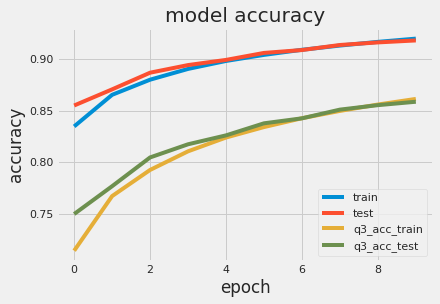

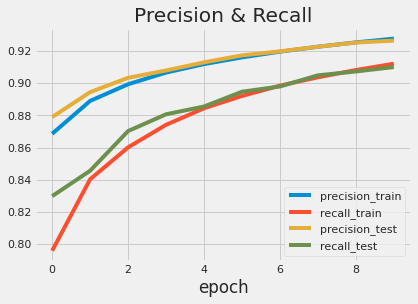

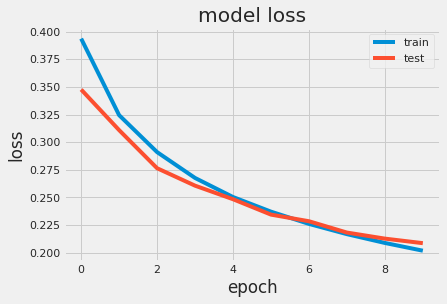

In [ ]:
hist = history.history

metrics = list()
for i in hist.keys():
    metrics.append(i)


# summarize history for accuracy
plt.plot(history.history[metrics[1]])
plt.plot(history.history[metrics[6]])
plt.plot(history.history[metrics[2]])
plt.plot(history.history[metrics[7]])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test','q3_acc_train','q3_acc_test'], loc='best')
plt.show()
# summarize history for precision and recall
plt.plot(history.history[metrics[3]])
plt.plot(history.history[metrics[4]])
plt.plot(history.history[metrics[8]])
plt.plot(history.history[metrics[9]])
plt.title('Precision & Recall')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['precision_train', 'recall_train','precision_test','recall_test'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history.history[metrics[0]])
plt.plot(history.history[metrics[5]])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], )
plt.show()

training
---
Input: QVQLQQSGAEVKKPGSSVRVSCKASGGTFNNNAINWVRQAPGQGLEWMGGIIPMFGTAKYSQNFQGRVAITADESTGTASMELSSLRSEDTAVYYCARSRDLLLFPHHALSPWGRGTMVTVSSASTKGPSVFPLAPSSKSTSGGTAALGCLVKDYFPEPVTVSWNSGALTSGVHTFPAVLQSSGLYSLSSVVTVPSSSLGTQTYICNVNHKPSNTKVDKKVEPKSCDKTHHHHHH
Target: CCCEEECCCEEECCCCCEEEEEEECCCCCCCCEEEEEEECCCCCCEEEEEEECCCCEEEECCCCCCCEEEEEECCCCEEEEEECCCCHHHCEEEEEEEECCCCCCCCCCEEEECCCEEEEECCCCCECCEEEEECCCCCCCCCCEEEEEEEEEEEECCCCEEEEHHHCECCCEEECCCEECCCCCEEEEEEEEEEHHHCCCCCCEEEEEEHHHCEEEEEECCCCCCCCCCCCCCC
Result: CCEEEECCCEEECCCCCEEEEEEEECCCCCCCCEEEEEECCCCCCEEEEEECCCCCCEEECCCCCCCEEEEEECCCCEEEEEECCCCHHHCEEEEEEEEECCCCCCCCCCCCCCCCEEEEECCCCCECCEEEEECCCCCCCCCCEEEEEEEEEEEECCCCEEEEHHHCECCCEEECCCEECCCCCEEEEEEEEEEHHHCCCCCCEEEEEEHHHCEEEEEECCCCCCCCCCCCCCC


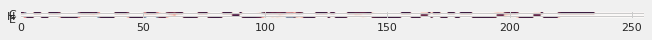

---
Input: MSNTLFDDIFQVSEVDPGRYNKVCRIEAASTTQDQCKLTLDINVELFPVAAQDSLTVTIASSLNLEDTPANDSSATRSWRPPQAGDRSLADDYDYVMYGTAYKFEEVSKDLIAVYYSFGGLLMRLEGNYRNLNNLKQENAYLLIRR
Target: CCCCCCEEEEEEEEEECCCCCCCEEEEEEECCCCCCEEEEEECCCCCCCCCCCEEEEECCCCCCCCCCCCCCCCCCCCCCCCCHHHCCCCCCCCEEEECEEEEEECCCCCCEEEEEEECCEEEEEEECCHHHCCCCCCCCEEEEEC
Result: CCCCCCEEEEEEEEEECCCCCCEEEEEEEECCCCCCEEEEEEECCCCCCCCCCEEEEECCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCEEEEEEEEEEEECCCCCEEEEEEECCEEEEEEECCCCCCCCCCCCCEEEEEC


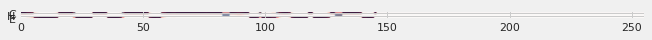

---
Input: KMLEGQNAHFRYKNR
Target: CHHHHHHHHHHCCCC
Result: HCCHHHHHHHHHCCC


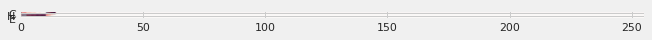

testing
---
Input: DLVNLLRCQEGPRNCRELLSQGATLSGWYHLCLPEGRALPVFCDMDTEGGGWLVFQRRQDGSVDFFRSWSSYRAGFGNQESEFWLGNENLHQLTLQGNWELRVELEDFNGNRTFAHYATFRLLGEVDHYQLALGKFSEGTAGDSLSLHSGRPFTTYDADHDSSNSNCAVIVHGAWWYASCYRSNLNGRYAVSEAAAHKYGIDWASGRGVGHPYRRVRMMLR
Target: CCCCCCCCCCCCCCHHHHHHCCCCCEEEEEEECCCCCEEEEEEECCHHHCCEEEEEEECCCCCCCCCCHHHHHHCEEECCCCEECCHHHHHHHHCCCCCCEEEEEECCCCCEEEEEECCEEECCHHHCCCEEECCECCCCCCCCCHHHCCCCCEECCECCCCCCCCHHHHCCCCECCCCCCCECCCCCCCCCCCCCCCCCCCECCCCCCCCCCCEEEEEEC
Result: CCEEECCCCCCCCHHHHHHHCCCCEEEEEEECCCCCCEEEEECCCCHCCCCEEEEEEECCCCCCCCHCHHHHHCCCCCCCCCEECCCCHHHHHHHCCCCEEEEEEEEECCCCEEEEEEEEEECCCCCCEEEEECCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCHHHHHHHCCCECCCCCCEECCCCCEEECCCHCHHCCCCHHCCCCCCCCCCCEEEECC


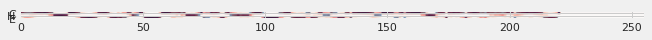

---
Input: MRIYSRLFQISSANYARQIMSNQFIKAKESKGLTYQQMAQLLSVNKVWLTSVLHGQNCCDIQLAHRICDTLGISHEYANELTSIPLRGNQNIINDPLIYRFNELFKVYGSSLRGIIHEEFGDGIMSAIDCKIDVTKNEQSRVILRIDGKFLPYYKGQLDAGENLYFQSAGHHHHHH
Target: CCCCCCCCCCCCCCCCCCCCCCHHHHHHHHHCCCHHHHHHHHCCCHHHHHHHHCCCCCCCHHHHHHHHHHCCCCHHHHHHHHCCCCCCCCCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHCCEEEEEEEEEEEEEECCCCEEEEEEEEEEEECCCCECCCCCCCCCCCCCCCCCCC
Result: CCCCCCCCCCCCCCCCCCCCCCHHHHHHHHHCCCHHHHHHHHCCCHHHHHHHHCCCCCCCHHHHHHHHHHCCCCHHHHHHHHHCCCCCCCCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHCCCEEEECEEEEEEECCCCCEEEEEECCCEEEEECCCCCCCCCCCCCCCCCCCCCC


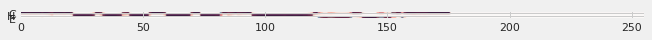

---
Input: AAPPPINKLALFPDKSAWCEAKNITQIVGHSGCEAKSIQNRACLGQCFSYSVPNTFPQSTESLVHCDSCMPAQSMWEIVTLECPGHEEVPRVDKLVEKILHCSCQACGKEPSHEGL
Target: CCCCCCCCCCCCCCCCCEEEEEEEEEEECCCCCCCEEEEEEEEEEEEEEEECCCCCCCCCCCCEEEEEEEEEEEEEEEEEEECCCCCCCCEEEEEEEEEEEEEEEECCCCCCCCCC
Result: CCCCCCCCCCCCCCCCCEECCCCEEEEECCCCCCCCEEEEEEECEEEEEEECCCCCCCCCCCHEHCCCEECCCCCEEEEEEECCCCCCCCCCCCCEEEEEEEECCCCCCCCCCCCC


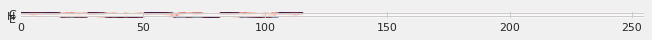

In [ ]:
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

def plot_results(x, y, y_):
    print("---")
    print("Input: " + str(x))
    print("Target: " + str(onehot_to_seq(y, revsere_decoder_index).upper()))
    print("Result: " + str(onehot_to_seq(y_, revsere_decoder_index).upper()))
    fig = plt.figure(figsize=(10,2))
    plt.imshow(y.T, cmap='Blues')
    plt.imshow(y_.T, cmap='Reds', alpha=.5)
    plt.yticks(range(4), [' '] + [revsere_decoder_index[i+1].upper() for i in range(3)])
    plt.show()
    
revsere_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()}
revsere_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()}

N=3
y_train_pred = model.predict(X_train[:N])
y_test_pred = model.predict(X_test[:N])
print('training')
for i in range(N):
    plot_results(seq_train[i], y_train[i], y_train_pred[i])
print('testing')
for i in range(N):
    plot_results(seq_test[i], y_test[i], y_test_pred[i])

## GRU

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_words, output_dim=128, input_length=maxlen_seq),
    tf.keras.layers.GRU(64,return_sequences=True, recurrent_dropout=0.1),
    tf.keras.layers.Dense(n_tags, activation='softmax'),
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 256, 128)          1077888   
                                                                 
 gru_5 (GRU)                 (None, 256, 64)           37248     
                                                                 
 dense_5 (Dense)             (None, 256, 4)            260       
                                                                 
Total params: 1,115,396
Trainable params: 1,115,396
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy", q3_acc,keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(X_train, y_train, batch_size=256, epochs=10 , validation_data=(X_test, y_test), verbose=1)
model.save("/content/drive/MyDrive/Protein/Models/GRUmodel.h5")

Epoch 1/10
132/132 [==============================] - 166s 1s/step - loss: 0.5225 - accuracy: 0.7733 - q3_acc: 0.5920 - precision_4: 0.8833 - recall_4: 0.6453 - val_loss: 0.4557 - val_accuracy: 0.7979 - val_q3_acc: 0.6332 - val_precision_4: 0.8327 - val_recall_4: 0.7619
Epoch 2/10
132/132 [==============================] - 158s 1s/step - loss: 0.4156 - accuracy: 0.8197 - q3_acc: 0.6745 - precision_4: 0.8594 - recall_4: 0.7761 - val_loss: 0.4166 - val_accuracy: 0.8172 - val_q3_acc: 0.6683 - val_precision_4: 0.8563 - val_recall_4: 0.7753
Epoch 3/10
132/132 [==============================] - 156s 1s/step - loss: 0.3988 - accuracy: 0.8283 - q3_acc: 0.6899 - precision_4: 0.8636 - recall_4: 0.7899 - val_loss: 0.3936 - val_accuracy: 0.8311 - val_q3_acc: 0.6936 - val_precision_4: 0.8626 - val_recall_4: 0.7980
Epoch 4/10
132/132 [==============================] - 155s 1s/step - loss: 0.3859 - accuracy: 0.8346 - q3_acc: 0.7013 - precision_4: 0.8667 - recall_4: 0.8000 - val_loss: 0.3925 - val_acc

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'q3_acc', 'precision_4', 'recall_4', 'val_loss', 'val_accuracy', 'val_q3_acc', 'val_precision_4', 'val_recall_4'])

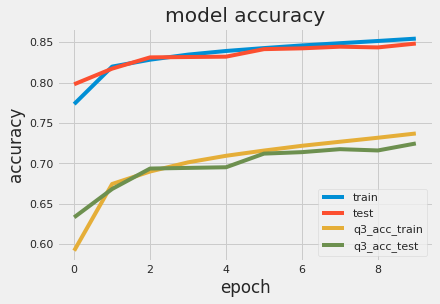

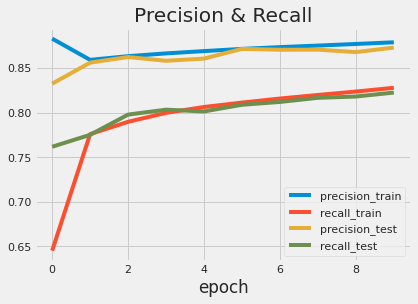

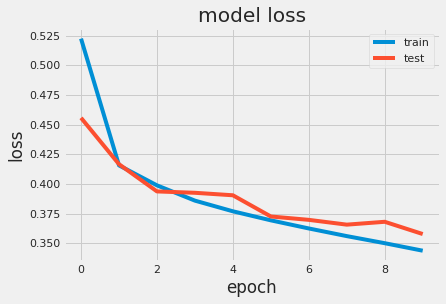

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['q3_acc'])
plt.plot(history.history['val_q3_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test','q3_acc_train','q3_acc_test'], loc='best')
plt.show()
# summarize history for precision and recall
plt.plot(history.history['precision_4'])
plt.plot(history.history['recall_4'])
plt.plot(history.history['val_precision_4'])
plt.plot(history.history['val_recall_4'])
plt.title('Precision & Recall')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['precision_train', 'recall_train','precision_test','recall_test'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], )
plt.show()

training
---
Input: MQIGRVRGTVVSSQKEPSMVGVKFLLLQLIDEAGQPLPQYEVAADGVGAGLDEWVLFSRGSAARQVAGSEKRPVDAVVIGIIDTVSVDNRPLYSKKDQYRGSHHHHHH
Target: CEEEEEEEEEEEEEECHHHCCCCEEEEEEECCCCCEEEEEEEEEECCCCCCCCEEEEEEHHHHHHCCCCCCCCCCEEEEEECCEEEECCEEEEECCCCCCCCCCCCCC
Result: CCCCEECEEEEECCCCCCEEEEEEEEEEECCCCCCCCCCEEEEECCCCCCCCHEEEEECCCHHHHHCCCCCCCCCEEEEEEECCECCCCCCCCCCCCCECCCCCCCCC


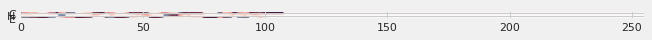

---
Input: MENLIGYVAAFLTTVSFLPAVLRVVMTKQTRDISRNMYIMFFLGVVLWFVYGILRSDLPIILANVVTLFFVTIILYYKLTEGNQTGSLEVLFQ
Target: CHHHHHHHHHHHHHHHCHHHHHHHHCCCCCCCHHHHHHHHHHHHHHHHHHHHHHCCCHHHHHHHHHHHHHHHHHHHHHHHCCCCCCCCHHHHC
Result: CCCCCCHHHHHHHHHHCCCHHHHHHHHCCCCCCCCCHHHHHHHHHHHHHHHHHHCCCCCCHHHHHHHHHHHHHHHHHHHHCCCCCCCHHHHCC


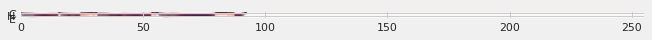

---
Input: QLTESMPFNVAEGKEVLLLVHNLPQQLFGYSWYKGERVDGNRQIVGYAIGTQQATPGPANSGRETIYPNASLLIQNVTQNDTGFYTLQVIKSDLVNEEATGQFHVYGGGGSGGGGSGGGGSGGGGSEVEYRAEVGQNAYLPCFYTPAAPGNLVPVCWGKGACPVFECGNVVLRTDERDVNYWTSRYWLNGDFRKGDVSLTIENVTLADSGIYCCRIQIPGIMNDEKFNLKHHHHHH
Target: CCCCCECCECCCCCCEEECCCCCCCCEEEEEEEECCCCCHHHEEEEEECCCCEEEECCCCCCCEEECCCCCEEECCCCHHHCEEEEEEEEECCCCCEEEEEEEECCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCEEEEEEECCCCCCCCCEEEEEECCCCEEEECCCCCCCEEECCCCCEEECCCCCCCCCEEEEEEEECCCCCECCCEECCCCCC
Result: CCCCCCCCCHCCCCCEEEEEECCCCCCCCEEEEECCCEECCEEEEEEEECCCCCCCCCCCCCCCEECCCCCEEEECCCCCCCCEEEEEEEECCCCCHCCCCCEEEECCCCCCCCCCCCCCCCCCCCCCEEEEECCCCEEEEEEECCCCCCCCEEEEECCCCCCEECCCCEEEECCCCCCCEEECCCEECCCCECCCEEEEEEEEEECCCEEEEEEEECCCCCCCHCCCCCCCCCCC


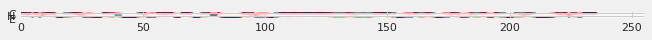

testing
---
Input: PPRFNIANVLLSPDGETFFRGFRSKIHAKGSLVCTGEGDENGVFVVVDGRLRVYLVGEEREISLFYLTSGDMFCMHSGCLVEATERTEVRFADIRTFEQKLQTCPSMAWGLIAILGRALTSCMRTIEDLMHHHHHH
Target: CCCCCCHHHHCCCCCCCCCCCCEEEEECCCCEEECCCCCCCCEEEEEECCEEEEECCCCCCEEEEEECCCCEEECCCCCEEEECCCEEEEEECHHHHHHHHHHCHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCCC
Result: CCCCCCCHEEECCCCCEEEEEECCCECCCCCEEECCCCCCCCEEEEECCCEEEEEECCCEEEEEEEEECCCEEECCCCCEEECCCCEEEEECCEEEHHHHHHCCCCCCCCHHHHHHHHHHHHHHHHHHHCCCCCCC


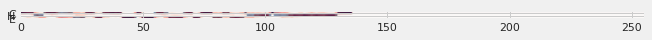

---
Input: AHHHHHHMSPLMVKVLDAVRGSPAINVAVHVFRKAADDTWEPFASGKTSESGELHGLTTEEEFVEGIYKVEIDTKSYWKALGISPFSEHAEVVFTANDSGPRRYTIAALLSPYSYSTTAVVTNPKE
Target: CCCCCCCCCCEEEEEEECCCCEECCCCEEEEEEECCCCCEEEEEEEECCCCCEECCCCCCCCCCCEEEEEEECHHHHHHHHCCCCCEEEEEEEEEECCCCCCEEEEEEEEECCEEEEEEEEECCCC
Result: CCCCCCCCCCEEEEEEECCCCCCCCCEEEEEEEECCCCCEEEEEEEECCCCCEEECCCCCCCCCCEEEEEEECCHHHHHHHCCCCCCCCEEEEEEECCCCCCEEEEEEEECCCCEEEEEEEECCCC


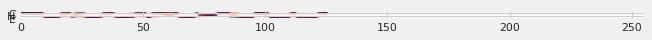

---
Input: CLSYETEILTVEYGLLPIGKIVEKRIECTVYSVDNNGNIYTQPVAQWHDRGEQEVFEYCLEDGSLIRATKDHKFMTVDGQMLPIDEIFERELDLMRVDNLPNLEGHHHHHH
Target: CEECCCEEEECCCEEEEHHHHHHCCCCCEEEEECCCCCEEEEECCEEEEEEEEEEEEEEECCCCEEEECCCCEEEECCCCEEEHHHHHHCCCEECECCCCCCCCCCCCCCC
Result: CCCCCCHHHHHHCCCCCCCEEHHHECECEEEECCCCCCEEECCCCEEECCCCEEEEEEEECCCCEEEEECCEEEEEECCEEEECHHHHHHHHCHHCCCCCCCCCCCCCCCC


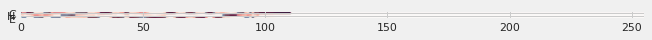

In [ ]:
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

def plot_results(x, y, y_):
    print("---")
    print("Input: " + str(x))
    print("Target: " + str(onehot_to_seq(y, revsere_decoder_index).upper()))
    print("Result: " + str(onehot_to_seq(y_, revsere_decoder_index).upper()))
    fig = plt.figure(figsize=(10,2))
    plt.imshow(y.T, cmap='Blues')
    plt.imshow(y_.T, cmap='Reds', alpha=.5)
    plt.yticks(range(4), [' '] + [revsere_decoder_index[i+1].upper() for i in range(3)])
    plt.show()
    
revsere_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()}
revsere_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()}

N=3
y_train_pred = model.predict(X_train[:N])
y_test_pred = model.predict(X_test[:N])
print('training')
for i in range(N):
    plot_results(seq_train[i], y_train[i], y_train_pred[i])
print('testing')
for i in range(N):
    plot_results(seq_test[i], y_test[i], y_test_pred[i])

## BiGRU

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_words, output_dim=128, input_length=maxlen_seq),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,return_sequences=True, recurrent_dropout=0.1)),
    tf.keras.layers.Dense(n_tags, activation='softmax'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 256, 128)          1077888   
                                                                 
 bidirectional_2 (Bidirectio  (None, 256, 128)         74496     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 256, 4)            516       
                                                                 
Total params: 1,152,900
Trainable params: 1,152,900
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy", q3_acc,keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(X_train, y_train, batch_size=256, epochs=20, validation_data=(X_test, y_test), verbose=1)
model.save("/content/drive/MyDrive/Protein/Models/BiGRUmodel.h5")

Epoch 1/20
132/132 [==============================] - 296s 2s/step - loss: 0.4986 - accuracy: 0.7792 - q3_acc: 0.6078 - precision_3: 0.8853 - recall_3: 0.6686 - val_loss: 0.3891 - val_accuracy: 0.8323 - val_q3_acc: 0.6957 - val_precision_3: 0.8675 - val_recall_3: 0.7938
Epoch 2/20
132/132 [==============================] - 290s 2s/step - loss: 0.3766 - accuracy: 0.8394 - q3_acc: 0.7100 - precision_3: 0.8698 - recall_3: 0.8061 - val_loss: 0.3702 - val_accuracy: 0.8424 - val_q3_acc: 0.7140 - val_precision_3: 0.8731 - val_recall_3: 0.8092
Epoch 3/20
132/132 [==============================] - 292s 2s/step - loss: 0.3568 - accuracy: 0.8494 - q3_acc: 0.7282 - precision_3: 0.8753 - recall_3: 0.8219 - val_loss: 0.3895 - val_accuracy: 0.8365 - val_q3_acc: 0.7033 - val_precision_3: 0.8595 - val_recall_3: 0.8141
Epoch 4/20
132/132 [==============================] - 286s 2s/step - loss: 0.3445 - accuracy: 0.8555 - q3_acc: 0.7391 - precision_3: 0.8790 - recall_3: 0.8305 - val_loss: 0.3454 - val_acc

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'q3_acc', 'precision_2', 'recall_2', 'val_loss', 'val_accuracy', 'val_q3_acc', 'val_precision_2', 'val_recall_2'])

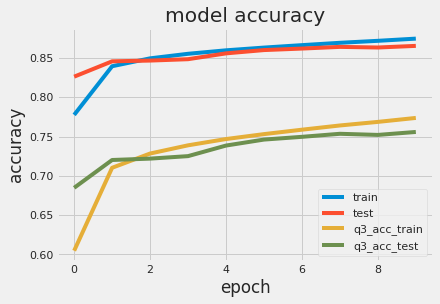

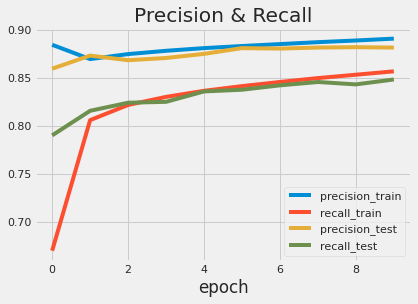

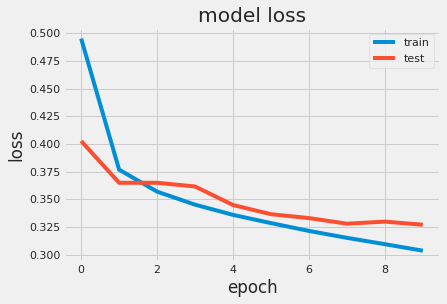

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['q3_acc'])
plt.plot(history.history['val_q3_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test','q3_acc_train','q3_acc_test'], loc='best')
plt.show()
# summarize history for precision and recall
plt.plot(history.history['precision_2'])
plt.plot(history.history['recall_2'])
plt.plot(history.history['val_precision_2'])
plt.plot(history.history['val_recall_2'])
plt.title('Precision & Recall')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['precision_train', 'recall_train','precision_test','recall_test'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], )
plt.show()

In [ ]:
# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model

model = load_model('/content/drive/MyDrive/Protein/Models/BiGRUmodel.h5',custom_objects={"q3_acc": q3_acc })
# summarize model.
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 256, 128)          1077888   
                                                                 
 bidirectional_2 (Bidirectio  (None, 256, 128)         74496     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 256, 4)            516       
                                                                 
Total params: 1,152,900
Trainable params: 1,152,900
Non-trainable params: 0
_________________________________________________________________


training
---
Input: MQIGRVRGTVVSSQKEPSMVGVKFLLLQLIDEAGQPLPQYEVAADGVGAGLDEWVLFSRGSAARQVAGSEKRPVDAVVIGIIDTVSVDNRPLYSKKDQYRGSHHHHHH
Target: CEEEEEEEEEEEEEECHHHCCCCEEEEEEECCCCCEEEEEEEEEECCCCCCCCEEEEEEHHHHHHCCCCCCCCCCEEEEEECCEEEECCEEEEECCCCCCCCCCCCCC
Result: CCCCEEEEEEEECCCCCCCCCCEEEEEEEECCCCCCCCEEEEEECCECCCCCCEEEEECCCCCEECCCCCCCCCCEEEEEEECCCCCCCCCCCCCCCCCCCCCCCCCC


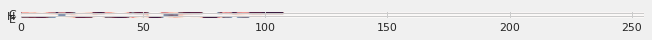

---
Input: MENLIGYVAAFLTTVSFLPAVLRVVMTKQTRDISRNMYIMFFLGVVLWFVYGILRSDLPIILANVVTLFFVTIILYYKLTEGNQTGSLEVLFQ
Target: CHHHHHHHHHHHHHHHCHHHHHHHHCCCCCCCHHHHHHHHHHHHHHHHHHHHHHCCCHHHHHHHHHHHHHHHHHHHHHHHCCCCCCCCHHHHC
Result: CCCHHHHHHHHHHHHHCCHHHHHHHCCCCCCCCCHHHHHHHHHHHHHHHHHHHHCCCHHHHHHHHHHHHHHHHHHHHHCCCCCCCCCCCCCCC


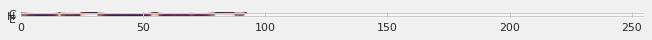

---
Input: QLTESMPFNVAEGKEVLLLVHNLPQQLFGYSWYKGERVDGNRQIVGYAIGTQQATPGPANSGRETIYPNASLLIQNVTQNDTGFYTLQVIKSDLVNEEATGQFHVYGGGGSGGGGSGGGGSGGGGSEVEYRAEVGQNAYLPCFYTPAAPGNLVPVCWGKGACPVFECGNVVLRTDERDVNYWTSRYWLNGDFRKGDVSLTIENVTLADSGIYCCRIQIPGIMNDEKFNLKHHHHHH
Target: CCCCCECCECCCCCCEEECCCCCCCCEEEEEEEECCCCCHHHEEEEEECCCCEEEECCCCCCCEEECCCCCEEECCCCHHHCEEEEEEEEECCCCCEEEEEEEECCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCEEEEEEECCCCCCCCCEEEEEECCCCEEEECCCCCCCEEECCCCCEEECCCCCCCCCEEEEEEEECCCCCECCCEECCCCCC
Result: CCCCEECEEECCCCCEEEEEEECCCCEEEEEEEECCCCCCCCEEEEEEECCCCCCCCCCCCCCEEECCCCEEEEECCCHCCCCEEEEEEECCCCCCCEEECEEEEECCCCCCCCCCCCCCCCCCCCCCEEEEECCCCCEEEEEECCCCCCCCEEEEECCCCCCCCCCCCEEEECCCCCCCEEECCEEECCCEEECCEEEEEEHCCHHCCCEEEEEEECCCCCCCCCCCCCCCCCCC


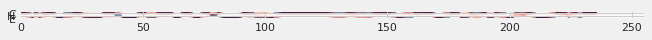

testing
---
Input: PPRFNIANVLLSPDGETFFRGFRSKIHAKGSLVCTGEGDENGVFVVVDGRLRVYLVGEEREISLFYLTSGDMFCMHSGCLVEATERTEVRFADIRTFEQKLQTCPSMAWGLIAILGRALTSCMRTIEDLMHHHHHH
Target: CCCCCCHHHHCCCCCCCCCCCCEEEEECCCCEEECCCCCCCCEEEEEECCEEEEECCCCCCEEEEEECCCCEEECCCCCEEEECCCEEEEEECHHHHHHHHHHCHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCCC
Result: CCCCCEEEEEECCCCCCEEEEEEEEEHCCCEEEECCCCCCCCEEEEEECEEEEEEECCCCEEEEEEECCCCEECCCCCCCCECCCCEEEECCCHCCCCCCCCCCHHHHHHHHHHHHHHHHHHHHHHHCCCCCCCCC


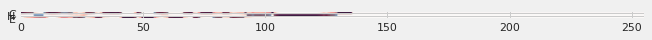

---
Input: AHHHHHHMSPLMVKVLDAVRGSPAINVAVHVFRKAADDTWEPFASGKTSESGELHGLTTEEEFVEGIYKVEIDTKSYWKALGISPFSEHAEVVFTANDSGPRRYTIAALLSPYSYSTTAVVTNPKE
Target: CCCCCCCCCCEEEEEEECCCCEECCCCEEEEEEECCCCCEEEEEEEECCCCCEECCCCCCCCCCCEEEEEEECHHHHHHHHCCCCCEEEEEEEEEECCCCCCEEEEEEEEECCEEEEEEEEECCCC
Result: CCCCCCCCCCEEEEEEECCCCEECCCCEEEEEEECCCCCEEEEEEEECCCCCEECCCCCCCCCCCEEEEEEECHHHHHHHCCCCCCCCCEEEEEEECCCCCCEEEEEEEEECCEEEEEEEEECCCC


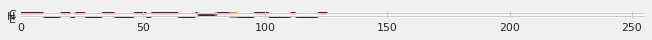

---
Input: CLSYETEILTVEYGLLPIGKIVEKRIECTVYSVDNNGNIYTQPVAQWHDRGEQEVFEYCLEDGSLIRATKDHKFMTVDGQMLPIDEIFERELDLMRVDNLPNLEGHHHHHH
Target: CEECCCEEEECCCEEEEHHHHHHCCCCCEEEEECCCCCEEEEECCEEEEEEEEEEEEEEECCCCEEEECCCCEEEECCCCEEEHHHHHHCCCEECECCCCCCCCCCCCCCC
Result: CCCCCCEEEEEECCCEECHHHHCCEEEEEEEECCCCCCEEECCCCEEEECCCCEEEEEEECCCCEEEECCCCEEEEECCCCCCHHHHHHHHCCCCECCCCCCCCCCCCCCC


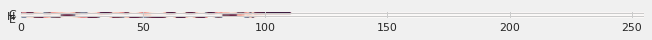

In [ ]:
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

def plot_results(x, y, y_):
    print("---")
    print("Input: " + str(x))
    print("Target: " + str(onehot_to_seq(y, revsere_decoder_index).upper()))
    print("Result: " + str(onehot_to_seq(y_, revsere_decoder_index).upper()))
    fig = plt.figure(figsize=(10,2))
    plt.imshow(y.T, cmap='Blues')
    plt.imshow(y_.T, cmap='Reds', alpha=.5)
    plt.yticks(range(4), [' '] + [revsere_decoder_index[i+1].upper() for i in range(3)])
    plt.show()
    
revsere_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()}
revsere_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()}

N=3
y_train_pred = model.predict(X_train[:N])
y_test_pred = model.predict(X_test[:N])
print('training')
for i in range(N):
    plot_results(seq_train[i], y_train[i], y_train_pred[i])
print('testing')
for i in range(N):
    plot_results(seq_test[i], y_test[i], y_test_pred[i])

## RNN

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_words, output_dim=128, input_length=maxlen_seq),
    tf.keras.layers.SimpleRNN(64,return_sequences=True, recurrent_dropout=0.1),
    tf.keras.layers.Dense(n_tags, activation='softmax'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 256, 128)          1077888   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 256, 64)           12352     
                                                                 
 dense_7 (Dense)             (None, 256, 4)            260       
                                                                 
Total params: 1,090,500
Trainable params: 1,090,500
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy", q3_acc,keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(X_train, y_train, batch_size=256, epochs=20, validation_data=(X_test, y_test), verbose=1)
model.save("/content/drive/MyDrive/Protein/Models/RNNmodel.h5")

Epoch 1/20
132/132 [==============================] - 68s 497ms/step - loss: 0.5279 - accuracy: 0.7649 - q3_acc: 0.5854 - precision_8: 0.8677 - recall_8: 0.6610 - val_loss: 0.4135 - val_accuracy: 0.8222 - val_q3_acc: 0.6774 - val_precision_8: 0.8567 - val_recall_8: 0.7856
Epoch 2/20
132/132 [==============================] - 67s 505ms/step - loss: 0.4146 - accuracy: 0.8216 - q3_acc: 0.6779 - precision_8: 0.8592 - recall_8: 0.7809 - val_loss: 0.4010 - val_accuracy: 0.8280 - val_q3_acc: 0.6879 - val_precision_8: 0.8598 - val_recall_8: 0.7945
Epoch 3/20
132/132 [==============================] - 64s 486ms/step - loss: 0.3982 - accuracy: 0.8296 - q3_acc: 0.6924 - precision_8: 0.8634 - recall_8: 0.7934 - val_loss: 0.3937 - val_accuracy: 0.8313 - val_q3_acc: 0.6940 - val_precision_8: 0.8608 - val_recall_8: 0.8006
Epoch 4/20
132/132 [==============================] - 63s 480ms/step - loss: 0.3891 - accuracy: 0.8342 - q3_acc: 0.7007 - precision_8: 0.8661 - recall_8: 0.8003 - val_loss: 0.3819 -

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'q3_acc', 'precision_8', 'recall_8', 'val_loss', 'val_accuracy', 'val_q3_acc', 'val_precision_8', 'val_recall_8'])

In [ ]:
hist = history.history

metrics = list()
for i in hist.keys():
    metrics.append(i)

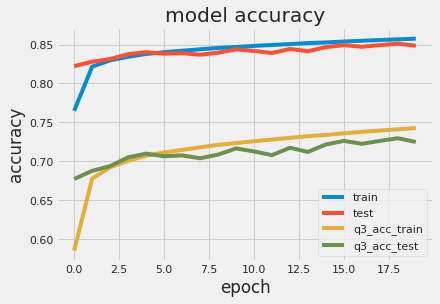

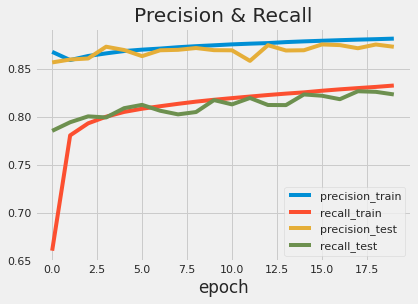

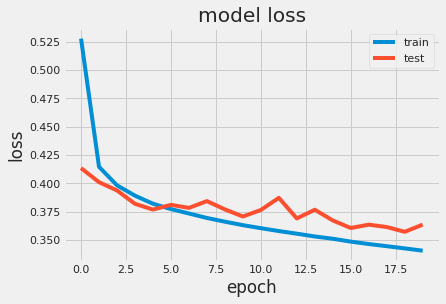

In [ ]:
# summarize history for accuracy
plt.plot(history.history[metrics[1]])
plt.plot(history.history[metrics[6]])
plt.plot(history.history[metrics[2]])
plt.plot(history.history[metrics[7]])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test','q3_acc_train','q3_acc_test'], loc='best')
plt.show()
# summarize history for precision and recall
plt.plot(history.history[metrics[3]])
plt.plot(history.history[metrics[4]])
plt.plot(history.history[metrics[8]])
plt.plot(history.history[metrics[9]])
plt.title('Precision & Recall')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['precision_train', 'recall_train','precision_test','recall_test'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history.history[metrics[0]])
plt.plot(history.history[metrics[5]])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], )
plt.show()

In [ ]:
# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model

model = load_model('/content/drive/MyDrive/Protein/Models/RNNmodel.h5',custom_objects={"q3_acc": q3_acc })
# summarize model.
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 256, 128)          1077888   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 256, 64)           12352     
                                                                 
 dense_7 (Dense)             (None, 256, 4)            260       
                                                                 
Total params: 1,090,500
Trainable params: 1,090,500
Non-trainable params: 0
_________________________________________________________________


training
---
Input: MQIGRVRGTVVSSQKEPSMVGVKFLLLQLIDEAGQPLPQYEVAADGVGAGLDEWVLFSRGSAARQVAGSEKRPVDAVVIGIIDTVSVDNRPLYSKKDQYRGSHHHHHH
Target: CEEEEEEEEEEEEEECHHHCCCCEEEEEEECCCCCEEEEEEEEEECCCCCCCCEEEEEEHHHHHHCCCCCCCCCCEEEEEECCEEEECCEEEEECCCCCCCCCCCCCC
Result: CECCEEEEEEEECCCCCCECCCEEEEEEEECCCCCCCCEEEEEECCCCCCHHHHEEECCCCHHHHHECCCCCCCCEEEEEEECEEEECCCCEECCCCCCCCCCCCCCC


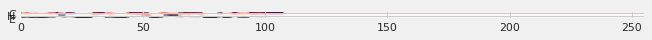

---
Input: MENLIGYVAAFLTTVSFLPAVLRVVMTKQTRDISRNMYIMFFLGVVLWFVYGILRSDLPIILANVVTLFFVTIILYYKLTEGNQTGSLEVLFQ
Target: CHHHHHHHHHHHHHHHCHHHHHHHHCCCCCCCHHHHHHHHHHHHHHHHHHHHHHCCCHHHHHHHHHHHHHHHHHHHHHHHCCCCCCCCHHHHC
Result: CCCCEEHHHHHHHHHHCCHHHHHHHHHCCHHCHHHHHHHHHHHEEHEHHHHHHHCHCCCEEHEEEEHHHEEHHHHHHHHCCCCCCCCEHHHCC


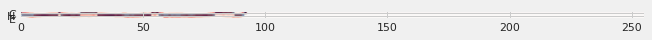

---
Input: QLTESMPFNVAEGKEVLLLVHNLPQQLFGYSWYKGERVDGNRQIVGYAIGTQQATPGPANSGRETIYPNASLLIQNVTQNDTGFYTLQVIKSDLVNEEATGQFHVYGGGGSGGGGSGGGGSGGGGSEVEYRAEVGQNAYLPCFYTPAAPGNLVPVCWGKGACPVFECGNVVLRTDERDVNYWTSRYWLNGDFRKGDVSLTIENVTLADSGIYCCRIQIPGIMNDEKFNLKHHHHHH
Target: CCCCCECCECCCCCCEEECCCCCCCCEEEEEEEECCCCCHHHEEEEEECCCCEEEECCCCCCCEEECCCCCEEECCCCHHHCEEEEEEEEECCCCCEEEEEEEECCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCEEEEEEECCCCCCCCCEEEEEECCCCEEEECCCCCCCEEECCCCCEEECCCCCCCCCEEEEEEEECCCCCECCCEECCCCCC
Result: CCCCCCCCCHCCCCEEEEEEECCCCCEECEEEEECCCCCCCEEEEEEEECCCCCCCCCCCCCCCEECCCCEEEEECCCCCCCEEEEEEEEECCCCCCCCEEEEEEECCCCCCCCCCCCCCCCCCCCCCCEEEECCCCHEECEEECCCCCCCCEEEEECCCCCCCCCCCEEEEECCCCCCEEEECCEEECCCECCCCEEEEEEEEEECCCCEEEEEEECCCCCCCCCECCCCCCCCC


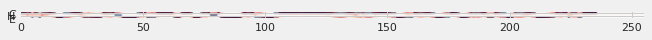

testing
---
Input: PPRFNIANVLLSPDGETFFRGFRSKIHAKGSLVCTGEGDENGVFVVVDGRLRVYLVGEEREISLFYLTSGDMFCMHSGCLVEATERTEVRFADIRTFEQKLQTCPSMAWGLIAILGRALTSCMRTIEDLMHHHHHH
Target: CCCCCCHHHHCCCCCCCCCCCCEEEEECCCCEEECCCCCCCCEEEEEECCEEEEECCCCCCEEEEEECCCCEEECCCCCEEEECCCEEEEEECHHHHHHHHHHCHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCCC
Result: CCCECCCHEEECCCCEEEECCECCCEECCCCEEECCCCCCCCEEEEEECCEEEEEECCCEEEEEEEEECCEEEECCCCCEEEEEECEEEEECCEEEHCHHHHCCCCHHHHHHHHHHHHHHHHHHHHHHHCCCCCCC


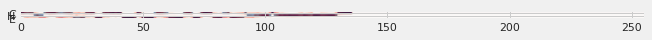

---
Input: AHHHHHHMSPLMVKVLDAVRGSPAINVAVHVFRKAADDTWEPFASGKTSESGELHGLTTEEEFVEGIYKVEIDTKSYWKALGISPFSEHAEVVFTANDSGPRRYTIAALLSPYSYSTTAVVTNPKE
Target: CCCCCCCCCCEEEEEEECCCCEECCCCEEEEEEECCCCCEEEEEEEECCCCCEECCCCCCCCCCCEEEEEEECHHHHHHHHCCCCCEEEEEEEEEECCCCCCEEEEEEEEECCEEEEEEEEECCCC
Result: CCCCCCCCCCEEEEEEECCCCCECCCCEEEEEEECCCCCEEEEEEEECCCCCEEECCCCCCCCCCEEEEEEECCHHHHHHCCCCCCCCHHEEEEEECCCCCCEEEEEEEECCCEEEEEEEEECCCC


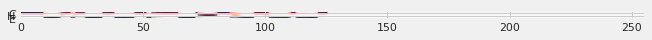

---
Input: CLSYETEILTVEYGLLPIGKIVEKRIECTVYSVDNNGNIYTQPVAQWHDRGEQEVFEYCLEDGSLIRATKDHKFMTVDGQMLPIDEIFERELDLMRVDNLPNLEGHHHHHH
Target: CEECCCEEEECCCEEEEHHHHHHCCCCCEEEEECCCCCEEEEECCEEEEEEEEEEEEEEECCCCEEEECCCCEEEECCCCEEEHHHHHHCCCEECECCCCCCCCCCCCCCC
Result: CCCCCHHHHEHCCCCEECCEHHEHEEEEEEEECCCCCCEEECCCCEEEECCCEEEEEEEEECCCEEEEECCECEEEECCEEECHHHHHHHHHCHCCCHCCCCCCCCCCCCC


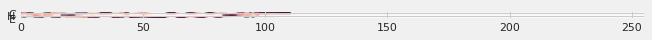

In [ ]:
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

def plot_results(x, y, y_):
    print("---")
    print("Input: " + str(x))
    print("Target: " + str(onehot_to_seq(y, revsere_decoder_index).upper()))
    print("Result: " + str(onehot_to_seq(y_, revsere_decoder_index).upper()))
    fig = plt.figure(figsize=(10,2))
    plt.imshow(y.T, cmap='Blues')
    plt.imshow(y_.T, cmap='Reds', alpha=.5)
    plt.yticks(range(4), [' '] + [revsere_decoder_index[i+1].upper() for i in range(3)])
    plt.show()
    
revsere_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()}
revsere_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()}

N=3
y_train_pred = model.predict(X_train[:N])
y_test_pred = model.predict(X_test[:N])
print('training')
for i in range(N):
    plot_results(seq_train[i], y_train[i], y_train_pred[i])
print('testing')
for i in range(N):
    plot_results(seq_test[i], y_test[i], y_test_pred[i])

## Bi RNN

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_words, output_dim=128, input_length=maxlen_seq),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64,return_sequences=True, recurrent_dropout=0.1)),
    tf.keras.layers.Dense(n_tags, activation='softmax'),
])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 256, 128)          1077888   
                                                                 
 bidirectional_3 (Bidirectio  (None, 256, 128)         24704     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 256, 4)            516       
                                                                 
Total params: 1,103,108
Trainable params: 1,103,108
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy", q3_acc,keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(X_train, y_train, batch_size=256, epochs=10, validation_data=(X_test, y_test), verbose=1)
model.save("/content/drive/MyDrive/Protein/Models/BiRNNmodel_q8.h5")

Epoch 1/10
132/132 [==============================] - 121s 898ms/step - loss: 0.5046 - accuracy: 0.7745 - q3_acc: 0.6027 - precision_9: 0.8721 - recall_9: 0.6773 - val_loss: 0.3926 - val_accuracy: 0.8327 - val_q3_acc: 0.6965 - val_precision_9: 0.8565 - val_recall_9: 0.8077
Epoch 2/10
132/132 [==============================] - 115s 870ms/step - loss: 0.3732 - accuracy: 0.8424 - q3_acc: 0.7155 - precision_9: 0.8713 - recall_9: 0.8112 - val_loss: 0.3574 - val_accuracy: 0.8497 - val_q3_acc: 0.7273 - val_precision_9: 0.8790 - val_recall_9: 0.8185
Epoch 3/10
132/132 [==============================] - 119s 899ms/step - loss: 0.3530 - accuracy: 0.8525 - q3_acc: 0.7338 - precision_9: 0.8775 - recall_9: 0.8257 - val_loss: 0.3459 - val_accuracy: 0.8561 - val_q3_acc: 0.7390 - val_precision_9: 0.8801 - val_recall_9: 0.8311
Epoch 4/10
132/132 [==============================] - 127s 962ms/step - loss: 0.3412 - accuracy: 0.8583 - q3_acc: 0.7441 - precision_9: 0.8811 - recall_9: 0.8341 - val_loss: 0.38

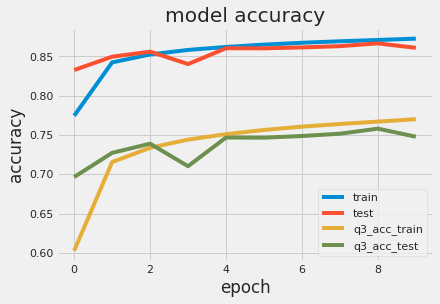

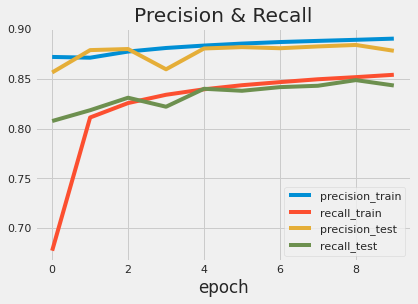

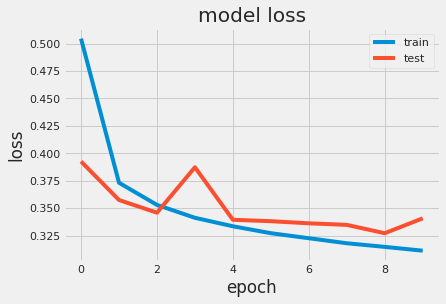

In [ ]:
hist = history.history
metrics = list()
for i in hist.keys():
    metrics.append(i)

# summarize history for accuracy
plt.plot(history.history[metrics[1]])
plt.plot(history.history[metrics[6]])
plt.plot(history.history[metrics[2]])
plt.plot(history.history[metrics[7]])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test','q3_acc_train','q3_acc_test'], loc='best')
plt.show()
# summarize history for precision and recall
plt.plot(history.history[metrics[3]])
plt.plot(history.history[metrics[4]])
plt.plot(history.history[metrics[8]])
plt.plot(history.history[metrics[9]])
plt.title('Precision & Recall')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['precision_train', 'recall_train','precision_test','recall_test'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history.history[metrics[0]])
plt.plot(history.history[metrics[5]])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], )
plt.show()

training
---
Input: MQIGRVRGTVVSSQKEPSMVGVKFLLLQLIDEAGQPLPQYEVAADGVGAGLDEWVLFSRGSAARQVAGSEKRPVDAVVIGIIDTVSVDNRPLYSKKDQYRGSHHHHHH
Target: CEEEEEEEEEEEEEECHHHCCCCEEEEEEECCCCCEEEEEEEEEECCCCCCCCEEEEEEHHHHHHCCCCCCCCCCEEEEEECCEEEECCEEEEECCCCCCCCCCCCCC
Result: CECCEEEEEEEECCCCCCEEEEEEEEEEEHHCCCCCCCCEEEEECCEECCCCHEEEECCCCHHCHHHCCCCCCCCEEEEEEECEECCCCCCCECCCCCCCCCCCCCCC


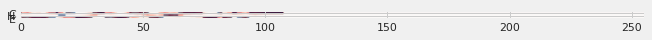

---
Input: MENLIGYVAAFLTTVSFLPAVLRVVMTKQTRDISRNMYIMFFLGVVLWFVYGILRSDLPIILANVVTLFFVTIILYYKLTEGNQTGSLEVLFQ
Target: CHHHHHHHHHHHHHHHCHHHHHHHHCCCCCCCHHHHHHHHHHHHHHHHHHHHHHCCCHHHHHHHHHHHHHHHHHHHHHHHCCCCCCCCHHHHC
Result: HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHECCCCCCCCCHHHHCC


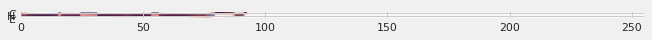

---
Input: QLTESMPFNVAEGKEVLLLVHNLPQQLFGYSWYKGERVDGNRQIVGYAIGTQQATPGPANSGRETIYPNASLLIQNVTQNDTGFYTLQVIKSDLVNEEATGQFHVYGGGGSGGGGSGGGGSGGGGSEVEYRAEVGQNAYLPCFYTPAAPGNLVPVCWGKGACPVFECGNVVLRTDERDVNYWTSRYWLNGDFRKGDVSLTIENVTLADSGIYCCRIQIPGIMNDEKFNLKHHHHHH
Target: CCCCCECCECCCCCCEEECCCCCCCCEEEEEEEECCCCCHHHEEEEEECCCCEEEECCCCCCCEEECCCCCEEECCCCHHHCEEEEEEEEECCCCCEEEEEEEECCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCEEEEEEECCCCCCCCCEEEEEECCCCEEEECCCCCCCEEECCCCCEEECCCCCCCCCEEEEEEEECCCCCECCCEECCCCCC
Result: CCCCCCCEEHHCCCEEEEEEECCCCCCCEEEEEECCCCCCCEEEEEEEECECCCCCCCCCCCCEEECCCCEEEEECECCCCCEEEEEEEEEEEECCCCCCCEEEEECCCCCCCCCCCCCCCCCCCCCCEEEEEECCEEEEEEEECCCCCCCCCCEEECCCCCCCCCCCEEEEEECCCCCCEEEHHEEEECCCECCCEEEEECCEEHCCCCEEEEEEEECCCCCCHCCCCCCCCCCC


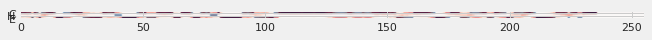

testing
---
Input: PPRFNIANVLLSPDGETFFRGFRSKIHAKGSLVCTGEGDENGVFVVVDGRLRVYLVGEEREISLFYLTSGDMFCMHSGCLVEATERTEVRFADIRTFEQKLQTCPSMAWGLIAILGRALTSCMRTIEDLMHHHHHH
Target: CCCCCCHHHHCCCCCCCCCCCCEEEEECCCCEEECCCCCCCCEEEEEECCEEEEECCCCCCEEEEEECCCCEEECCCCCEEEECCCEEEEEECHHHHHHHHHHCHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCCC
Result: CCCCCCEEEEECCCCCEEEECEECEEEEEEEEEEEEECCCCEEEEEEEEEEEEEEEEEEEEEEEEHECCCCEECCCCCHHEEEECEEEEEEHCHHHHHHHHHHCHHHHHHHHHHHHHHHHHHHHHHHCCCCCCCCC


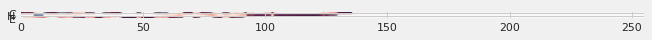

---
Input: AHHHHHHMSPLMVKVLDAVRGSPAINVAVHVFRKAADDTWEPFASGKTSESGELHGLTTEEEFVEGIYKVEIDTKSYWKALGISPFSEHAEVVFTANDSGPRRYTIAALLSPYSYSTTAVVTNPKE
Target: CCCCCCCCCCEEEEEEECCCCEECCCCEEEEEEECCCCCEEEEEEEECCCCCEECCCCCCCCCCCEEEEEEECHHHHHHHHCCCCCEEEEEEEEEECCCCCCEEEEEEEEECCEEEEEEEEECCCC
Result: CCCCCCCCCCEEEEEEECCCCEECCCCEEEEEEECCCCCEEEEEEEECCCCCEECCCCCCCCCCCEEEEEEECHHHHHHHCCCCCCCCCEEEEEEECCCCCCEEEEEEEECCCEEEEEEEEECCCC


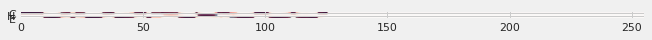

---
Input: CLSYETEILTVEYGLLPIGKIVEKRIECTVYSVDNNGNIYTQPVAQWHDRGEQEVFEYCLEDGSLIRATKDHKFMTVDGQMLPIDEIFERELDLMRVDNLPNLEGHHHHHH
Target: CEECCCEEEECCCEEEEHHHHHHCCCCCEEEEECCCCCEEEEECCEEEEEEEEEEEEEEECCCCEEEECCCCEEEECCCCEEEHHHHHHCCCEECECCCCCCCCCCCCCCC
Result: CCCCCEEEEEHHHCECCCCEEEEEEEEEEEEEECCCCEEEEECCEEEEEECCCEEEEEEECCCCEEEEECCEEEEEECCCEECHHHHHHHHHHHHHHCCCCCCCCCCCCCC


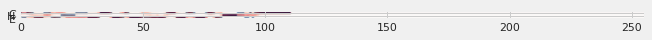

In [ ]:
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

def plot_results(x, y, y_):
    print("---")
    print("Input: " + str(x))
    print("Target: " + str(onehot_to_seq(y, revsere_decoder_index).upper()))
    print("Result: " + str(onehot_to_seq(y_, revsere_decoder_index).upper()))
    fig = plt.figure(figsize=(10,2))
    plt.imshow(y.T, cmap='Blues')
    plt.imshow(y_.T, cmap='Reds', alpha=.5)
    plt.yticks(range(4), [' '] + [revsere_decoder_index[i+1].upper() for i in range(3)])
    plt.show()
    
revsere_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()}
revsere_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()}

N=3
y_train_pred = model.predict(X_train[:N])
y_test_pred = model.predict(X_test[:N])
print('training')
for i in range(N):
    plot_results(seq_train[i], y_train[i], y_train_pred[i])
print('testing')
for i in range(N):
    plot_results(seq_test[i], y_test[i], y_test_pred[i])

#For Q8

In [ ]:
def seq2ngrams(seqs, n=3):
    return np.array([[seq[i:i+n] for i in range(len(seq))] for seq in seqs])

## Preprocessing

In [ ]:
maxlen_seq = 256
input_seqs, target_seqs = df[['seq', 'sst8']][(df.len <= maxlen_seq) & (~df.has_nonstd_aa)].values.T
input_grams = seq2ngrams(input_seqs)
print(input_grams[0])
print(input_seqs[0])
print(target_seqs[0])
print(len(input_seqs))
print(len(target_seqs))

['MVL', 'VLS', 'LSE', 'SEG', 'EGE', 'GEW', 'EWQ', 'WQL', 'QLV', 'LVL', 'VLH', 'LHV', 'HVW', 'VWA', 'WAK', 'AKV', 'KVE', 'VEA', 'EAD', 'ADV', 'DVA', 'VAG', 'AGH', 'GHG', 'HGQ', 'GQD', 'QDI', 'DIL', 'ILI', 'LIR', 'IRL', 'RLF', 'LFK', 'FKS', 'KSH', 'SHP', 'HPE', 'PET', 'ETL', 'TLE', 'LEK', 'EKF', 'KFD', 'FDR', 'DRV', 'RVK', 'VKH', 'KHL', 'HLK', 'LKT', 'KTE', 'TEA', 'EAE', 'AEM', 'EMK', 'MKA', 'KAS', 'ASE', 'SED', 'EDL', 'DLK', 'LKK', 'KKH', 'KHG', 'HGV', 'GVT', 'VTV', 'TVL', 'VLT', 'LTA', 'TAL', 'ALG', 'LGA', 'GAI', 'AIL', 'ILK', 'LKK', 'KKK', 'KKG', 'KGH', 'GHH', 'HHE', 'HEA', 'EAE', 'AEL', 'ELK', 'LKP', 'KPL', 'PLA', 'LAQ', 'AQS', 'QSH', 'SHA', 'HAT', 'ATK', 'TKH', 'KHK', 'HKI', 'KIP', 'IPI', 'PIK', 'IKY', 'KYL', 'YLE', 'LEF', 'EFI', 'FIS', 'ISE', 'SEA', 'EAI', 'AII', 'IIH', 'IHV', 'HVL', 'VLH', 'LHS', 'HSR', 'SRH', 'RHP', 'HPG', 'PGN', 'GNF', 'NFG', 'FGA', 'GAD', 'ADA', 'DAQ', 'AQG', 'QGA', 'GAM', 'AMN', 'MNK', 'NKA', 'KAL', 'ALE', 'LEL', 'ELF', 'LFR', 'FRK', 'RKD', 'KDI', 'DIA', 'IAA'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
print("input_data[0]")
tokenizer_encoder = Tokenizer()
tokenizer_encoder.fit_on_texts(input_grams)
input_data = tokenizer_encoder.texts_to_sequences(input_grams)
print(input_data[0])
input_data = sequence.pad_sequences(input_data, maxlen=maxlen_seq, padding='post')
print(input_data[0])

print("target_data[0]")
tokenizer_decoder = Tokenizer(char_level=True)
tokenizer_decoder.fit_on_texts(target_seqs)
target_data = tokenizer_decoder.texts_to_sequences(target_seqs)
print(target_data[0])
target_data = sequence.pad_sequences(target_data, maxlen=maxlen_seq, padding='post')
print(target_data[0])
target_data = to_categorical(target_data)
print(target_data[0])
input_data.shape, target_data.shape

input_data[0]
[3049, 217, 73, 533, 450, 4247, 5828, 5637, 605, 173, 3293, 2981, 7395, 5729, 4603, 451, 181, 148, 1214, 583, 620, 165, 1883, 2754, 5097, 3377, 2499, 578, 1409, 737, 1935, 1850, 2130, 2666, 3956, 2996, 3930, 1698, 130, 113, 20, 1511, 3853, 2966, 1119, 1313, 4209, 3289, 2552, 682, 2065, 937, 139, 3444, 3267, 3310, 734, 964, 839, 304, 687, 124, 3680, 3306, 3273, 472, 3, 185, 203, 190, 492, 22, 373, 838, 665, 262, 124, 300, 343, 3373, 2937, 4615, 4229, 139, 78, 140, 915, 1396, 363, 884, 2626, 3844, 3950, 4913, 1016, 4180, 1725, 4101, 2222, 2675, 3900, 4151, 1562, 990, 2035, 3103, 2592, 1552, 1091, 292, 755, 4360, 4462, 3087, 3293, 2322, 4555, 3745, 3508, 3223, 2779, 4354, 4254, 1066, 278, 179, 2709, 1068, 2127, 2484, 4094, 4923, 2170, 31, 16, 42, 1262, 2691, 1669, 3174, 688, 254, 183, 119, 2434, 3072, 2788, 40, 310, 2431, 4036, 3299, 6059, 138]
[3049  217   73  533  450 4247 5828 5637  605  173 3293 2981 7395 5729
 4603  451  181  148 1214  583  620  165 1883 2754 5097 3377 

((226733, 256), (226733, 256, 9))

In [ ]:
n_words = len(tokenizer_encoder.word_index) + 1
n_tags = len(tokenizer_decoder.word_index) + 1
print(n_words, n_tags)

8421 9


## Bi LSTM

In [ ]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional

input = Input(shape=(maxlen_seq,))
x = Embedding(input_dim=n_words, output_dim=128, input_length=maxlen_seq)(input)
x = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.1))(x)
y = TimeDistributed(Dense(n_tags, activation="softmax"))(x)
model = Model(input, y)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256)]             0         
                                                                 
 embedding (Embedding)       (None, 256, 128)          1077888   
                                                                 
 bidirectional (Bidirectiona  (None, 256, 128)         98816     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 256, 9)           1161      
 ibuted)                                                         
                                                                 
Total params: 1,177,865
Trainable params: 1,177,865
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.model_selection import train_test_split
from keras.metrics import categorical_accuracy
from keras import backend  as K
import tensorflow as tf
import keras

In [ ]:
def q8_acc(y_true, y_pred):
    y = tf.argmax(y_true, axis=-1)
    y_ = tf.argmax(y_pred, axis=-1)
    mask = tf.greater(y, 0)
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=.4, random_state=0)
seq_train, seq_test, target_train, target_test = train_test_split(input_seqs, target_seqs, test_size=.4, random_state=0)

In [ ]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy", q8_acc,keras.metrics.Precision(),keras.metrics.Recall()])
history = model.fit(X_train, y_train, batch_size=256, epochs=10, validation_data=(X_test, y_test), verbose=1)
model.save("/content/drive/MyDrive/Protein/Models/BiLSTMmodel_q8.h5")

Epoch 1/10
532/532 [==============================] - 1445s 3s/step - loss: 0.5787 - accuracy: 0.7972 - q8_acc: 0.6494 - precision_1: 0.8981 - recall_1: 0.7178 - val_loss: 0.5202 - val_accuracy: 0.8205 - val_q8_acc: 0.6902 - val_precision_1: 0.9109 - val_recall_1: 0.7470
Epoch 2/10
532/532 [==============================] - 1381s 3s/step - loss: 0.4971 - accuracy: 0.8281 - q8_acc: 0.7027 - precision_1: 0.9054 - recall_1: 0.7667 - val_loss: 0.4688 - val_accuracy: 0.8386 - val_q8_acc: 0.7214 - val_precision_1: 0.9067 - val_recall_1: 0.7861
Epoch 3/10
532/532 [==============================] - 1480s 3s/step - loss: 0.4543 - accuracy: 0.8432 - q8_acc: 0.7289 - precision_1: 0.9115 - recall_1: 0.7896 - val_loss: 0.4377 - val_accuracy: 0.8499 - val_q8_acc: 0.7410 - val_precision_1: 0.9129 - val_recall_1: 0.8011
Epoch 4/10
532/532 [==============================] - 1470s 3s/step - loss: 0.4231 - accuracy: 0.8542 - q8_acc: 0.7479 - precision_1: 0.9162 - recall_1: 0.8057 - val_loss: 0.4139 - val

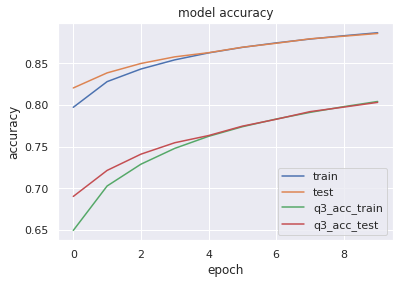

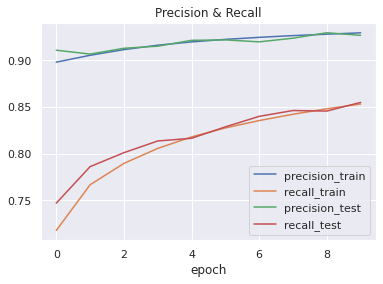

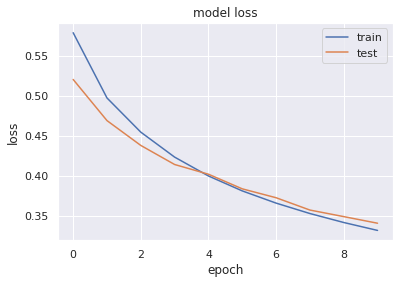

In [ ]:
hist = history.history

metrics = list()
for i in hist.keys():
    metrics.append(i)

# summarize history for accuracy
plt.plot(history.history[metrics[1]])
plt.plot(history.history[metrics[6]])
plt.plot(history.history[metrics[2]])
plt.plot(history.history[metrics[7]])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test','q3_acc_train','q3_acc_test'], loc='best')
plt.show()
# summarize history for precision and recall
plt.plot(history.history[metrics[3]])
plt.plot(history.history[metrics[4]])
plt.plot(history.history[metrics[8]])
plt.plot(history.history[metrics[9]])
plt.title('Precision & Recall')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['precision_train', 'recall_train','precision_test','recall_test'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history.history[metrics[0]])
plt.plot(history.history[metrics[5]])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], )
plt.show()

training
---
Input: MTITPSLKGFFIGLLSGAVVLGLTFAVLIAISQIDKVQRSL
Target: CCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHTTCCCCCCC
Result: CCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCCCC


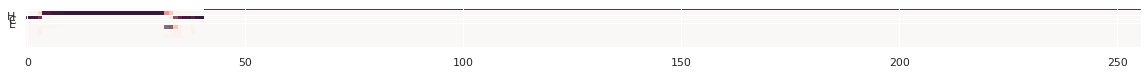

---
Input: MSKQPDKQRKSQRRAPLHERHKQVRATLSADLREEYGQRNVRVNAGDTVEVLRGDFAGEEGEVINVDLDKAVIHVEDVTLEKTDGEEVPRPLDTSNVRVTDLDLEDEKREARLESEDDSA
Target: CCCCHHHHHHHHHSCCGGGGGGGGEEEECHHHHHHHSCSEEECCTTCEEEECSSTTTTCEEEEEEEETTTTEEEETTCEEECTTSCEEECCBCGGGEEEEECCCCSHHHHHHHHCTTSCC
Result: CCCCCHHHHHHHHSCCGGGGGGGEEEEECHHHHHHHTCSCEECCTTCEEEECSSTTTTCEEEEEEEETTTTEEEETTCEEECSTSCECECCCCGGGEEEECCCCCCCHHHHHHHCCCCCC


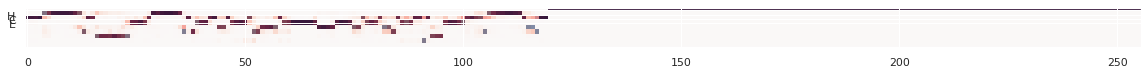

---
Input: KNHPMLMNLLKDN
Target: CCCHHHHHHTCCC
Result: CCCHHHHHHHCCC


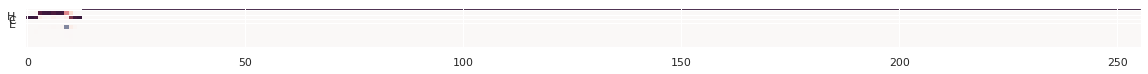

---
Input: MPGSIPLIGERFPEMEVTTDHGVIKLPDHYVSQGKWFVLFSHPADFTPVCTTEFVSFARRYEDFQRLGVDLIGLSVDSVFSHIKWKEWIERHIGVRIPFPIIADPQGTVARRLGLLHAESATHTVRGVFIVDARGVIRTMLYYPMELGRLVDEILRIVKALKLGDSLKRAVPADWPNNEIIGEGLIVPPPTTEDQARARMESGQYRCLDWWFCWDTPASRDDVEEARRYLRRAAEKPAKLLYEEARTHLH
Target: CCBCCCCTTSBCCCEEEEETTEEEEETHHHHTTTCEEEEEEESCSSCHHHHHHHHHHHHTHHHHHHTTEEEEEEESSCHHHHHHHHHHHHHHHSCCCCSCEEECSSTHHHHHTTCCCTTCSSSCCEEEEEECTTSBEEEEEEECTTBCCCHHHHHHHHHHHHHHHHTTCBBCTTTTSBTTTBTCEEECCCCSHHHHHHCCSTTTCCEEETTEEEECCSCHHHHHHHHHHHHHHHSCCSSCCCCCCCCCCC
Result: CCCEECCTTSBCCCEEEEETTEEEEETHHHHTTTCEEEEEECSCSSCHHHHHHHHHHHHTHHHHHHTTEEEEEEESSCHHHHHHHHHHHHHHTCCCCCSCEEECTGTHHHHHTTCCCSSCSSSCCEEEEEECTTSBEEEEEEECTTBCCCHHHHHHHHHHHHHHHHHTCBBCTTTTSBTTTTTCEEECCCCSHHHHHHHHHHCCSEEEETTEEEECCSCHHHHHHHHHHHHHHHSCCSSCCCCCCCCCCC


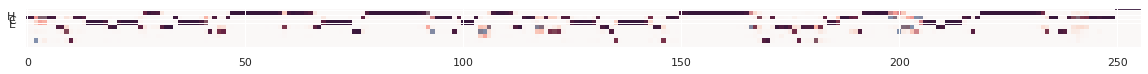

---
Input: MKSYEIALIGNPNVGKSTIFNALTGENVYIGNWPGVTVEKKEGEFEYNGEKFKVVDLPGVYSLTANSIDEIIARDYIINEKPDLVVNIVDATALERNLYLTLQLMEMGANLLLALNKMDLAKSLGIEIDVDKLEKILGVKVVPLSAAKKMGIEELKKAISIAVKD
Target: CCEEEEEEECSTTSSHHHHHHHHHCCSSSCCCCCCCCCCCCEEEEEETTEEEEEEECCCCSCSSSSSHHHHHHHHHHHHHCCSEEEEEEETTCHHHHHHHHHHHHHTTCCEEEEEECHHHHHHTTCCCCHHHHHHHHTSCEEECBGGGTBSHHHHHHHHHHHTTC
Result: CCCEEEEEEECTTCCHHHHHHHHHTSEEEEEECTTEEEEEEEEEEEETTCEEEEEECTTCCEECSCCHHHHHHHHHHHHTCCSEEEEEECHHHHHHHHHHHHHHHHTTCEEEEEEECHHHHHHHTCCCCHHHHHHHHTCEEEECCHHHHHCHHHHHHHHHCCCCC


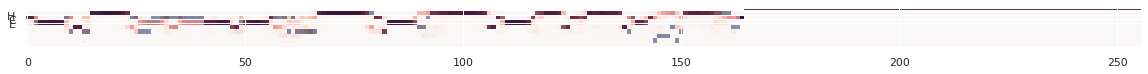

testing
---
Input: DLVNLLRCQEGPRNCRELLSQGATLSGWYHLCLPEGRALPVFCDMDTEGGGWLVFQRRQDGSVDFFRSWSSYRAGFGNQESEFWLGNENLHQLTLQGNWELRVELEDFNGNRTFAHYATFRLLGEVDHYQLALGKFSEGTAGDSLSLHSGRPFTTYDADHDSSNSNCAVIVHGAWWYASCYRSNLNGRYAVSEAAAHKYGIDWASGRGVGHPYRRVRMMLR
Target: CCCCCCCCCCCCSSHHHHHHTTCCSBEEEEEECTTSCEEEEEEESSGGGSCEEEEEEESSSCSCCCCCHHHHHHCEEETTSCEECCHHHHHHHHTSSCCCEEEEEECTTSCEEEEEESCEEECCGGGTTCEEECCBCCCTTCCCSGGGTTCCCBBTTBCCSSSSSCHHHHTTSCBCCSSSCSBCTTSCCCSSSTTCCSSCSCBTTTTCTTCCCSEEEEEEC
Result: CCCCEETTTCSCHHHHHHHHTTCCCCEEEEEECCTTEEEEEEEEEETTTSEEEEEEEETTSCCEEEECEEEECCCCCTCTCEEEECCHHHHEEEETTTEEEEEEEEECTSSEEEEEEEEEEEEEECEEEEEEEEEEEECCTTEEEEEETSEEEEEECCCCSSSSCCCCHHETTCCCCTCEEEECCTCCEEECCCCHCCTCCCCCCCCCCCCCEEEEEECCC


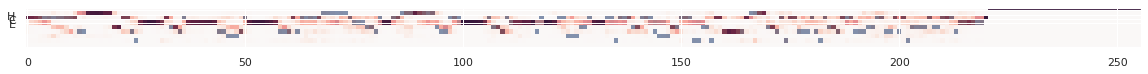

---
Input: MRIYSRLFQISSANYARQIMSNQFIKAKESKGLTYQQMAQLLSVNKVWLTSVLHGQNCCDIQLAHRICDTLGISHEYANELTSIPLRGNQNIINDPLIYRFNELFKVYGSSLRGIIHEEFGDGIMSAIDCKIDVTKNEQSRVILRIDGKFLPYYKGQLDAGENLYFQSAGHHHHHH
Target: CCCCCCCCCCCCCCCCCCCCCCHHHHHHHHHTCCHHHHHHHHTSCHHHHHHHHTTSSCCCHHHHHHHHHHSSCCGGGHHHHHSCCCCSCCCCTTSHHHHHHHHHHHHHHHHHHHHHHHHHCSEEEEEEEEEEEEEECTTSEEEEEEEEEEEECCCCBCCSCCCCCCCCCCCCCCCC
Result: CCCCCCCCCCCCCCCCCCCCCHHHHHHHHHHTCCHHHHHHHHHHHHHHHHHHHTSSSCSCHHHHHHHHHHTTCCSHHHHHHGTCCCCSCCCEHTCHHHHHHHHHHHHHHHHHHHHHHHHHTSSEEEEEEEEEEEEETTTEEEEEEEETEEEEECCCCCCCCCCCCCCCCCCCCCCC


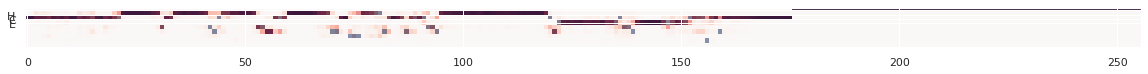

---
Input: AAPPPINKLALFPDKSAWCEAKNITQIVGHSGCEAKSIQNRACLGQCFSYSVPNTFPQSTESLVHCDSCMPAQSMWEIVTLECPGHEEVPRVDKLVEKILHCSCQACGKEPSHEGL
Target: CCCCCCCCCCCCCCCSCEEEEEEEEEEECCTTSCCEEEEEEEEEEEEEEEECCCCCCCCCCTTEEEEEEEEEEEEEEEEEEECTTCSSSSEEEEEEEEEEEEEEEETTSCSCCCCC
Result: CCCCCHHCEECCCCSSSECECEEEEEEECCSSCHCCCCEEEEEEEEEESSSCCTSCCCCCCEEEECTTEEETEESEEEEEEECCSCSSSCSCCEEEEHHHHHCCCCCCCCCCCCCC


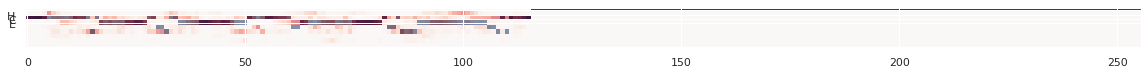

---
Input: GSHMQVTPRRNVLQKRPVIVKVLSTTKPFEYETPEMEKKIMFHATVATQTQFFHVKVLNTSLKEKFNGKKIIIISDYLEYDSLLEVNEESTVSEAGPNQTFEVPNKIINRAKETLKIDILHKQASGNIVYGVFMLHKKTVNQKTTIYEIQDDRGKMDVVGTGQCHNIPCEEGDKLQLFCFRLRKKNQMSKLISEMHSFIQIKKKTN
Target: CCCCCCCCCCCCCBCSCEEEEEEEECCCEEEECCCCCEEEEEEEEEECSSCEEEEEECCGGGGGGGSSSSEEEEESBEEETTEEEECTTCEEEECCGGGCCCCCHHHHHHHTCCCCHHHHTTSCTTCEEEEEEEEEEEEECSSEEEEEEEETTEEEEEEEEGGGSSCCCCTTCEEEEEEEEEEEETTEEEEECCTTCEEEECCCCC
Result: CCCCCCCCCCCCCCSSCEEEEEEEECCCEEEECCTSEEEEEEEEEEETTCEEEEEEEECHHHHTTTTTEEEEEEEEEETCCEEEEEEEEEEEEEECCTCEEEECHHHHHHHHHHHCCCHCHHTTTTCEEEEEEEEEEEEEEEEEEEEEEEETTEEEEEECCSCSSCCCCCTTCEEEEEEEEEEETTTEEEEEEEEEEEEECCCCCC


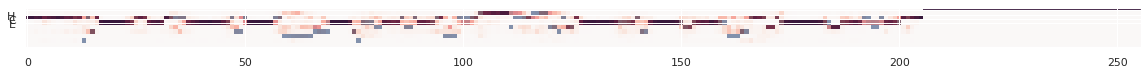

---
Input: DPLLDINGNVVEASRDYYLVSVIGGAGGGGLTLYRGRNELCPLDVIQLSPDLHKGTRLRFAAYNNTSIIHEAVDLNVKFSTETSCNEPTVWRVDNYDPSRGKWFITTGGVEGNPGAQTLKNWFKLERVGTDQGTYEIVHCPSVCKSCVFLCNDVGVSYDYRRRLALTAGNERVFGVVIVPANEGSASCVS
Target: CBCBCTTSCBCBTTSCBEEEEEEEETTEEEEEEECCSSSSCSCEEEECSCTTCCBSCEEEEETTCCSBCBTTSCEEEEESSCCSSCSCCBCEECCCCTTTTCCBEESCCCCCCSSSSSGGGCBEEEECSSSSSCEEEEECCCSCTTCCCCCEEEEEEGGGTTEEEEECSCSCCCCEEEECCSSSCCCCCC
Result: CTHHCTTCCEHCHCTCEEEEEEETCCCCCCEEEEEECCCCCCCSEEEECTTCCCTEEEEEEETTTCCEEEEEEEETCEEEEECCCCCSEEEEECSCCTTTEEEEEEEESCCSCTCCCEGGGGEEEEEEECCSEEEEEEECESCCEEEEEEEEEEEEEEEEEEEEEEECSCCCEEEEEEEEECCCCCCCCC


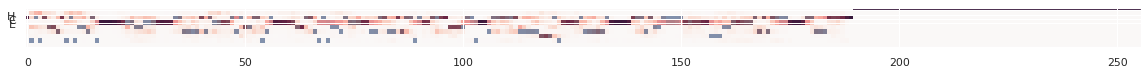

In [ ]:
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

def plot_results(x, y, y_):
    print("---")
    print("Input: " + str(x))
    print("Target: " + str(onehot_to_seq(y, revsere_decoder_index).upper()))
    print("Result: " + str(onehot_to_seq(y_, revsere_decoder_index).upper()))
    fig = plt.figure(figsize=(20,10))
    plt.imshow(y.T, cmap='Blues')
    plt.imshow(y_.T, cmap='Reds', alpha=.5)
    plt.yticks(range(4), [' '] + [revsere_decoder_index[i+1].upper() for i in range(3)])
    plt.show()
    
revsere_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()}
revsere_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()}

N=5
y_train_pred = model.predict(X_train[:N])
y_test_pred = model.predict(X_test[:N])
print('training')
for i in range(N):
    plot_results(seq_train[i], y_train[i], y_train_pred[i])
print('testing')
for i in range(N):
    plot_results(seq_test[i], y_test[i], y_test_pred[i])

## LSTM

In [ ]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_words, output_dim=128, input_length=maxlen_seq),
    tf.keras.layers.LSTM(64,return_sequences=True, recurrent_dropout=0.1),
    tf.keras.layers.Dense(n_tags, activation='softmax'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 256, 128)          1077888   
                                                                 
 lstm_1 (LSTM)               (None, 256, 64)           49408     
                                                                 
 dense_1 (Dense)             (None, 256, 9)            585       
                                                                 
Total params: 1,127,881
Trainable params: 1,127,881
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy", q8_acc,keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(X_train, y_train, batch_size=256, epochs=10, validation_data=(X_test, y_test), verbose=1)
model.save("/content/drive/MyDrive/Protein/Models/LSTMmodel.h5")

Epoch 1/10
532/532 [==============================] - 755s 1s/step - loss: 0.6950 - accuracy: 0.7522 - q8_acc: 0.5717 - precision_3: 0.8940 - recall_3: 0.6387 - val_loss: 0.6049 - val_accuracy: 0.7863 - val_q8_acc: 0.6312 - val_precision_3: 0.8921 - val_recall_3: 0.7021
Epoch 2/10
532/532 [==============================] - 708s 1s/step - loss: 0.5686 - accuracy: 0.7992 - q8_acc: 0.6528 - precision_3: 0.8982 - recall_3: 0.7220 - val_loss: 0.5321 - val_accuracy: 0.8130 - val_q8_acc: 0.6772 - val_precision_3: 0.9032 - val_recall_3: 0.7436
Epoch 3/10
532/532 [==============================] - 720s 1s/step - loss: 0.5192 - accuracy: 0.8175 - q8_acc: 0.6845 - precision_3: 0.9052 - recall_3: 0.7502 - val_loss: 0.4962 - val_accuracy: 0.8264 - val_q8_acc: 0.7003 - val_precision_3: 0.9061 - val_recall_3: 0.7666
Epoch 4/10
532/532 [==============================] - 717s 1s/step - loss: 0.4860 - accuracy: 0.8299 - q8_acc: 0.7058 - precision_3: 0.9099 - recall_3: 0.7689 - val_loss: 0.4702 - val_acc

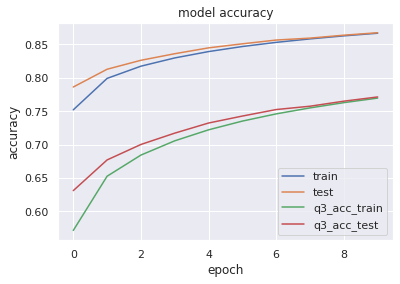

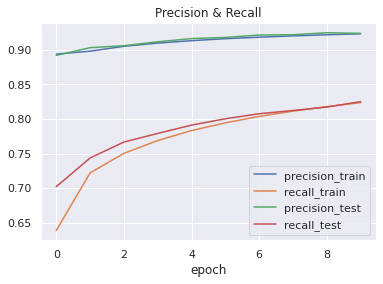

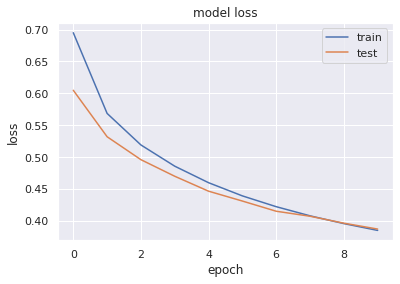

In [ ]:
hist = history.history

metrics = list()
for i in hist.keys():
    metrics.append(i)


# summarize history for accuracy
plt.plot(history.history[metrics[1]])
plt.plot(history.history[metrics[6]])
plt.plot(history.history[metrics[2]])
plt.plot(history.history[metrics[7]])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test','q3_acc_train','q3_acc_test'], loc='best')
plt.show()
# summarize history for precision and recall
plt.plot(history.history[metrics[3]])
plt.plot(history.history[metrics[4]])
plt.plot(history.history[metrics[8]])
plt.plot(history.history[metrics[9]])
plt.title('Precision & Recall')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['precision_train', 'recall_train','precision_test','recall_test'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history.history[metrics[0]])
plt.plot(history.history[metrics[5]])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], )
plt.show()

training
---
Input: MTITPSLKGFFIGLLSGAVVLGLTFAVLIAISQIDKVQRSL
Target: CCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHTTCCCCCCC
Result: CCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHTCCCCCCC


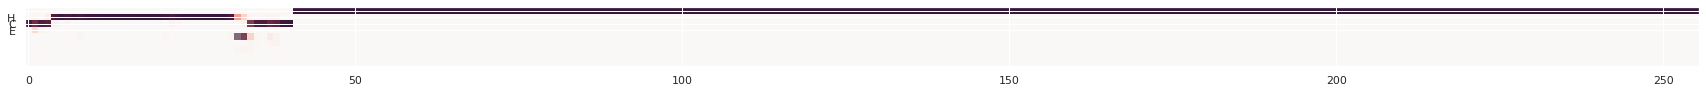

---
Input: MSKQPDKQRKSQRRAPLHERHKQVRATLSADLREEYGQRNVRVNAGDTVEVLRGDFAGEEGEVINVDLDKAVIHVEDVTLEKTDGEEVPRPLDTSNVRVTDLDLEDEKREARLESEDDSA
Target: CCCCHHHHHHHHHSCCGGGGGGGGEEEECHHHHHHHSCSEEECCTTCEEEECSSTTTTCEEEEEEEETTTTEEEETTCEEECTTSCEEECCBCGGGEEEEECCCCSHHHHHHHHCTTSCC
Result: CCCCHHHHHHHHHSCCGGGGGGGGEEEECHHHHHHHTCSEEECCTTCEEEECSSTTTTCEEEEEEEETTTTEEEETTCEEECTTSCEEECCCCGGGEEEEECCCCCHHHHHHHHCCTCCC


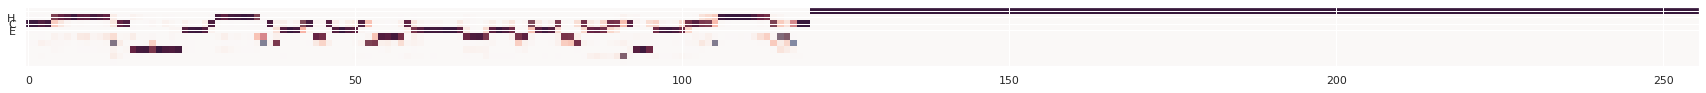

---
Input: KNHPMLMNLLKDN
Target: CCCHHHHHHTCCC
Result: CCCHHHHHHHHCC


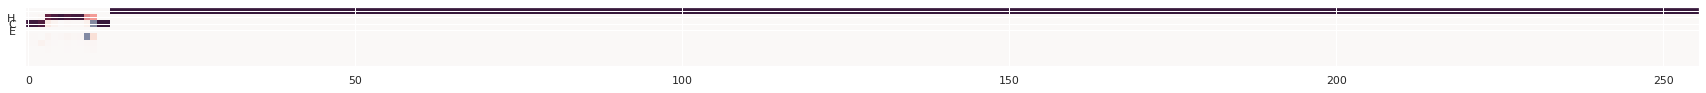

testing
---
Input: DLVNLLRCQEGPRNCRELLSQGATLSGWYHLCLPEGRALPVFCDMDTEGGGWLVFQRRQDGSVDFFRSWSSYRAGFGNQESEFWLGNENLHQLTLQGNWELRVELEDFNGNRTFAHYATFRLLGEVDHYQLALGKFSEGTAGDSLSLHSGRPFTTYDADHDSSNSNCAVIVHGAWWYASCYRSNLNGRYAVSEAAAHKYGIDWASGRGVGHPYRRVRMMLR
Target: CCCCCCCCCCCCSSHHHHHHTTCCSBEEEEEECTTSCEEEEEEESSGGGSCEEEEEEESSSCSCCCCCHHHHHHCEEETTSCEECCHHHHHHHHTSSCCCEEEEEECTTSCEEEEEESCEEECCGGGTTCEEECCBCCCTTCCCSGGGTTCCCBBTTBCCSSSSSCHHHHTTSCBCCSSSCSBCTTSCCCSSSTTCCSSCSCBTTTTCTTCCCSEEEEEEC
Result: CCEHHHHCCCCCSCCGGGHHTTCCCCEEEEETCCTTCCEEEEEEECCTCCCEEEEEECTTSCCSEEEEEEEEETTTCSCCCEEEECCCTHHHEEEEECEEEEEEEEETTTSEEEEEEEEEEEEEECCEEEEEEEECCTCCCCCCEEECCCCCCCEECTCSCCCCCCEEEEEEEEBCCCEECSSCCTSCEEECCCHHHHHCCCHTTCCCECCCTHHHHHHEC


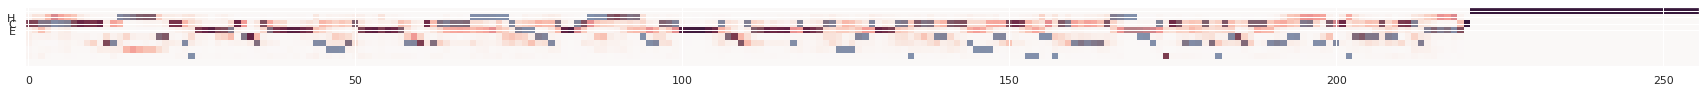

---
Input: MRIYSRLFQISSANYARQIMSNQFIKAKESKGLTYQQMAQLLSVNKVWLTSVLHGQNCCDIQLAHRICDTLGISHEYANELTSIPLRGNQNIINDPLIYRFNELFKVYGSSLRGIIHEEFGDGIMSAIDCKIDVTKNEQSRVILRIDGKFLPYYKGQLDAGENLYFQSAGHHHHHH
Target: CCCCCCCCCCCCCCCCCCCCCCHHHHHHHHHTCCHHHHHHHHTSCHHHHHHHHTTSSCCCHHHHHHHHHHSSCCGGGHHHHHSCCCCSCCCCTTSHHHHHHHHHHHHHHHHHHHHHHHHHCSEEEEEEEEEEEEEECTTSEEEEEEEEEEEECCCCBCCSCCCCCCCCCCCCCCCC
Result: CCEECCHHCCCCTCCCCCHECHHHHHHHHHTTCCHHHHHHHHHHHHHHHHHHHTCCCCCCHHHHHHHHHHHCCCHHHHHHHHSSCCTTCCCHSTCHHHHHHHHHHHHHCHHHHHHHHHHHTSCEEEEEEEEEECCTCCCCEEEEEETTEEEEEESCCCCTTCCCCCCCCCCCCCCC


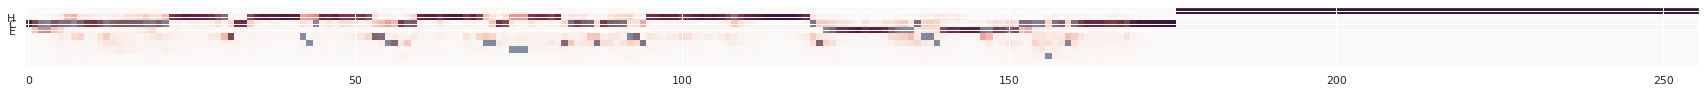

---
Input: AAPPPINKLALFPDKSAWCEAKNITQIVGHSGCEAKSIQNRACLGQCFSYSVPNTFPQSTESLVHCDSCMPAQSMWEIVTLECPGHEEVPRVDKLVEKILHCSCQACGKEPSHEGL
Target: CCCCCCCCCCCCCCCSCEEEEEEEEEEECCTTSCCEEEEEEEEEEEEEEEECCCCCCCCCCTTEEEEEEEEEEEEEEEEEEECTTCSSSSEEEEEEEEEEEEEEEETTSCSCCCCC
Result: CCCCCCCCHCCCCCCCCEEEEEEEEEEESCCSCEEEEEECEEETTEESEEECTTCCCCCCCEEEECCECCEEEETEEEEEEECTTCECCCEECEEEEEEEECCTCTTCCCCCCCCC


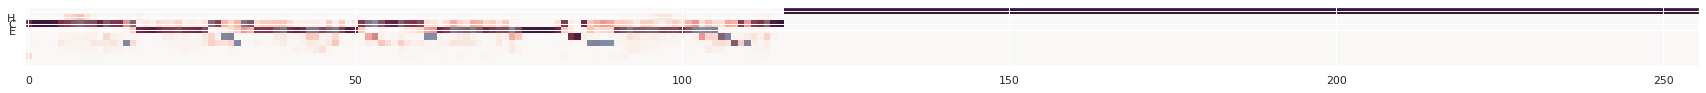

In [ ]:
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

def plot_results(x, y, y_):
    print("---")
    print("Input: " + str(x))
    print("Target: " + str(onehot_to_seq(y, revsere_decoder_index).upper()))
    print("Result: " + str(onehot_to_seq(y_, revsere_decoder_index).upper()))
    fig = plt.figure(figsize=(30,30))
    plt.imshow(y.T, cmap='Blues')
    plt.imshow(y_.T, cmap='Reds', alpha=.5)
    plt.yticks(range(4), [' '] + [revsere_decoder_index[i+1].upper() for i in range(3)])
    plt.show()
    
revsere_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()}
revsere_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()}

N=3
y_train_pred = model.predict(X_train[:N])
y_test_pred = model.predict(X_test[:N])
print('training')
for i in range(N):
    plot_results(seq_train[i], y_train[i], y_train_pred[i])
print('testing')
for i in range(N):
    plot_results(seq_test[i], y_test[i], y_test_pred[i])

## GRU

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_words, output_dim=128, input_length=maxlen_seq),
    tf.keras.layers.GRU(64,return_sequences=True, recurrent_dropout=0.1),
    tf.keras.layers.Dense(n_tags, activation='softmax'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 256, 128)          1077888   
                                                                 
 gru_4 (GRU)                 (None, 256, 64)           37248     
                                                                 
 dense_8 (Dense)             (None, 256, 9)            585       
                                                                 
Total params: 1,115,721
Trainable params: 1,115,721
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy", q8_acc,keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(X_train, y_train, batch_size=256, epochs=20 , validation_data=(X_test, y_test), verbose=1)
model.save("/content/drive/MyDrive/Protein/Models/GRUmodel_q8.h5")

Epoch 1/20
132/132 [==============================] - 133s 986ms/step - loss: 0.8939 - accuracy: 0.6855 - q8_acc: 0.4388 - precision_9: 0.9300 - recall_9: 0.5103 - val_loss: 0.7203 - val_accuracy: 0.7356 - val_q8_acc: 0.5203 - val_precision_9: 0.8919 - val_recall_9: 0.6137
Epoch 2/20
132/132 [==============================] - 130s 983ms/step - loss: 0.6831 - accuracy: 0.7518 - q8_acc: 0.5519 - precision_9: 0.8841 - recall_9: 0.6485 - val_loss: 0.6729 - val_accuracy: 0.7545 - val_q8_acc: 0.5546 - val_precision_9: 0.8771 - val_recall_9: 0.6620
Epoch 3/20
132/132 [==============================] - 130s 983ms/step - loss: 0.6561 - accuracy: 0.7627 - q8_acc: 0.5715 - precision_9: 0.8846 - recall_9: 0.6677 - val_loss: 0.6467 - val_accuracy: 0.7670 - val_q8_acc: 0.5773 - val_precision_9: 0.8798 - val_recall_9: 0.6817
Epoch 4/20
132/132 [==============================] - 130s 987ms/step - loss: 0.6391 - accuracy: 0.7695 - q8_acc: 0.5839 - precision_9: 0.8864 - recall_9: 0.6791 - val_loss: 0.64

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'q8_acc', 'precision_9', 'recall_9', 'val_loss', 'val_accuracy', 'val_q8_acc', 'val_precision_9', 'val_recall_9'])

In [ ]:
hist = history.history

metrics = list()
for i in hist.keys():
    metrics.append(i)

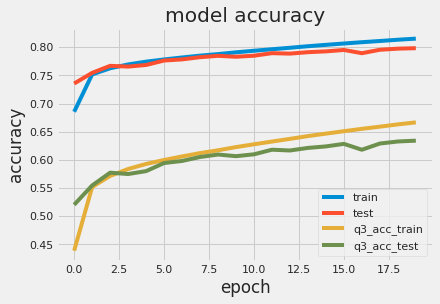

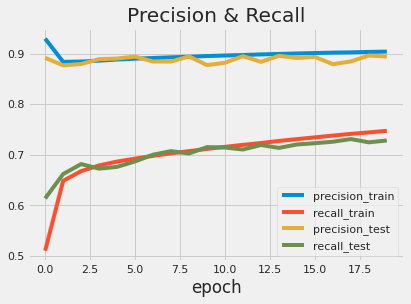

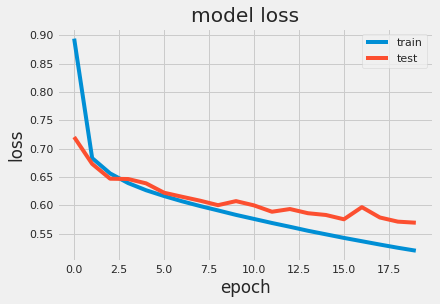

In [ ]:
# summarize history for accuracy
plt.plot(history.history[metrics[1]])
plt.plot(history.history[metrics[6]])
plt.plot(history.history[metrics[2]])
plt.plot(history.history[metrics[7]])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test','q3_acc_train','q3_acc_test'], loc='best')
plt.show()
# summarize history for precision and recall
plt.plot(history.history[metrics[3]])
plt.plot(history.history[metrics[4]])
plt.plot(history.history[metrics[8]])
plt.plot(history.history[metrics[9]])
plt.title('Precision & Recall')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['precision_train', 'recall_train','precision_test','recall_test'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history.history[metrics[0]])
plt.plot(history.history[metrics[5]])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], )
plt.show()

training
---
Input: MQIGRVRGTVVSSQKEPSMVGVKFLLLQLIDEAGQPLPQYEVAADGVGAGLDEWVLFSRGSAARQVAGSEKRPVDAVVIGIIDTVSVDNRPLYSKKDQYRGSHHHHHH
Target: CEEEEEEEEEEEEEECGGGTTCCEEEEEEECTTCCEEEEEEEEEESSCCCTTCEEEEEEGGGGGGSTTCTTSCCCEEEEEECCEEEETTEEEEECCCCCCCCCCCCCC
Result: CCEEEEEEEEEECCSCCEEEEEEEEEEEEEETTTCCCCEEEEEEEEEEETCHEEEEEETTCHHHHHHCCHCCCCCEEEEEEEEEEECCTCCEECCCCCCCCCCCCCCC


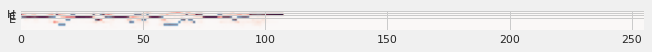

---
Input: MENLIGYVAAFLTTVSFLPAVLRVVMTKQTRDISRNMYIMFFLGVVLWFVYGILRSDLPIILANVVTLFFVTIILYYKLTEGNQTGSLEVLFQ
Target: CHHHHHHHHHHHHHHHTHHHHHHHHSCCTTTTHHHHHHHHHHHHHHHHHHHHHHTTCHHHHHHHHHHHHHHHHHHHHHHHSCSSCCSTHHHHC
Result: CCCCCEHHHHHHHHHHHCHHHHHHHHHHCCHCHHHHHHHHHHHHHHHHHHHHHHCHTSCHHHHHHHHHHHHHHHHHHHHCHTCCCCCHHHHCC


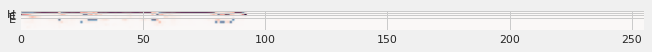

---
Input: QLTESMPFNVAEGKEVLLLVHNLPQQLFGYSWYKGERVDGNRQIVGYAIGTQQATPGPANSGRETIYPNASLLIQNVTQNDTGFYTLQVIKSDLVNEEATGQFHVYGGGGSGGGGSGGGGSGGGGSEVEYRAEVGQNAYLPCFYTPAAPGNLVPVCWGKGACPVFECGNVVLRTDERDVNYWTSRYWLNGDFRKGDVSLTIENVTLADSGIYCCRIQIPGIMNDEKFNLKHHHHHH
Target: CCCCCBTSBCCTTSCEEECCCSCCSSEEEEEEEESSSCCGGGEEEEEETTTTEEEECTTCCSCEEECTTSCEEECSCCGGGCEEEEEEEEETTSCCEEEEEEEBCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCSSCCCCCCCCSCCSSEEEEEEECSSSCCTTTEEEEEETTTTEEEECSSCCSSEEECSSSCEEESSCCSTTCSEEEEEEEETTSCCBCCCEECCCCCC
Result: CCCCCCCCCHCTTCCEEEEEEECCCEEECCEEEESCCEETCEEEEEEEEEEEEECCCCTTTCEEEEETTCEEEEEEECCSGCEEEEEEEEEEEEECEEEEEEEEEECCCCCCCCCCCCCCCCCCCCCCEEEEEETSTEEEEEEECCCCSSCCEEEEEETTSCCEEECCEEEEECCCTCCCEEESCEEETTCEETTCEEEEEEEEEECCTEEEEEEEEETTCCCCCEEEECCCCCCC


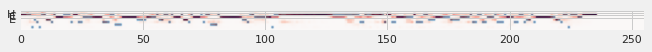

testing
---
Input: PPRFNIANVLLSPDGETFFRGFRSKIHAKGSLVCTGEGDENGVFVVVDGRLRVYLVGEEREISLFYLTSGDMFCMHSGCLVEATERTEVRFADIRTFEQKLQTCPSMAWGLIAILGRALTSCMRTIEDLMHHHHHH
Target: CCCCCTHHHHTSTTTTTTTTTCEEEEECTTCEEECSSCSCCCEEEEEESCEEEEECSTTCCEEEEEECTTCEEESCSSCEEEESSCEEEEEECHHHHHHHHHHCGGGHHHHHHHHHHHHHHHHHHHHHHHCCCCCC
Result: CCCEEEEEEEECTTTCEEEEEEEEEEEETTEEEEECTTCTTTEEEEETTTEEEEEEEEEEEEEEEEEEEECEEECSSCCCCCCCCCEEEEECCCEEHHHHHHTCCTGCCHHEEEEHHHHHHHHHHHHHHHCCCCCC


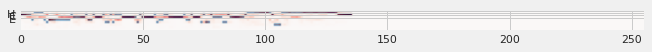

---
Input: AHHHHHHMSPLMVKVLDAVRGSPAINVAVHVFRKAADDTWEPFASGKTSESGELHGLTTEEEFVEGIYKVEIDTKSYWKALGISPFSEHAEVVFTANDSGPRRYTIAALLSPYSYSTTAVVTNPKE
Target: CCCCCCCCCCEEEEEEETTTTEECTTCEEEEEEECTTSCEEEEEEEECCTTSEECCSCCTTTCCSEEEEEEECHHHHHHHHTCCCSEEEEEEEEEECSSSCSEEEEEEEEETTEEEEEEEEECCCC
Result: CCCCCCCCCCEEEEEEEETTTEECETEEEEEEEECTTSCEEEEEEEECCTTSEECCSCCTTTCCSEEEEEEECHHHHHHHTTCCCCSGHHEEEEEESTTSCCEEEEEEEEETTEEEEEEEEECTCC


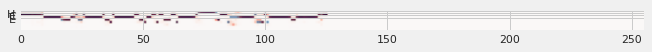

---
Input: CLSYETEILTVEYGLLPIGKIVEKRIECTVYSVDNNGNIYTQPVAQWHDRGEQEVFEYCLEDGSLIRATKDHKFMTVDGQMLPIDEIFERELDLMRVDNLPNLEGHHHHHH
Target: CEETTCEEEETTTEEEEHHHHHHTTCCCEEEEECTTSCEEEEECCEEEEEEEEEEEEEEETTSCEEEECTTCEEEBTTSCEEEHHHHHHTTCBBCBCSCCCCCCCCCCCCC
Result: CCCCHHHHHHHHHTCCCHHHHHHHHHHCEEEEECTTSCEEEECCCEEEEETCEEEEEEEETTSCEEEEEECCEEEEETTEEEEEEEHHHHHCCHEECCTCCCCCCCCCCCC


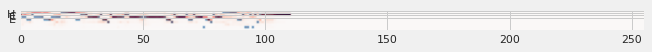

In [ ]:
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

def plot_results(x, y, y_):
    print("---")
    print("Input: " + str(x))
    print("Target: " + str(onehot_to_seq(y, revsere_decoder_index).upper()))
    print("Result: " + str(onehot_to_seq(y_, revsere_decoder_index).upper()))
    fig = plt.figure(figsize=(10,2))
    plt.imshow(y.T, cmap='Blues')
    plt.imshow(y_.T, cmap='Reds', alpha=.5)
    plt.yticks(range(4), [' '] + [revsere_decoder_index[i+1].upper() for i in range(3)])
    plt.show()
    
revsere_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()}
revsere_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()}

N=3
y_train_pred = model.predict(X_train[:N])
y_test_pred = model.predict(X_test[:N])
print('training')
for i in range(N):
    plot_results(seq_train[i], y_train[i], y_train_pred[i])
print('testing')
for i in range(N):
    plot_results(seq_test[i], y_test[i], y_test_pred[i])

## BiGRU

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_words, output_dim=128, input_length=maxlen_seq),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,return_sequences=True, recurrent_dropout=0.1)),
    tf.keras.layers.Dense(n_tags, activation='softmax'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 256, 128)          1077888   
                                                                 
 bidirectional_2 (Bidirectio  (None, 256, 128)         74496     
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 256, 9)            1161      
                                                                 
Total params: 1,153,545
Trainable params: 1,153,545
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy", q8_acc,keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(X_train, y_train, batch_size=256, epochs=20, validation_data=(X_test, y_test), verbose=1)
model.save("/content/drive/MyDrive/Protein/Models/BiGRUmodel_q8.h5")

Epoch 1/20
132/132 [==============================] - 255s 2s/step - loss: 0.8393 - accuracy: 0.7111 - q8_acc: 0.4784 - precision_8: 0.9227 - recall_8: 0.5409 - val_loss: 0.6611 - val_accuracy: 0.7626 - val_q8_acc: 0.5693 - val_precision_8: 0.8871 - val_recall_8: 0.6693
Epoch 2/20
132/132 [==============================] - 248s 2s/step - loss: 0.6441 - accuracy: 0.7697 - q8_acc: 0.5842 - precision_8: 0.8887 - recall_8: 0.6781 - val_loss: 0.6421 - val_accuracy: 0.7686 - val_q8_acc: 0.5802 - val_precision_8: 0.8883 - val_recall_8: 0.6772
Epoch 3/20
132/132 [==============================] - 250s 2s/step - loss: 0.6137 - accuracy: 0.7818 - q8_acc: 0.6061 - precision_8: 0.8908 - recall_8: 0.6972 - val_loss: 0.6091 - val_accuracy: 0.7844 - val_q8_acc: 0.6088 - val_precision_8: 0.8860 - val_recall_8: 0.7081
Epoch 4/20
132/132 [==============================] - 247s 2s/step - loss: 0.5934 - accuracy: 0.7896 - q8_acc: 0.6201 - precision_8: 0.8925 - recall_8: 0.7098 - val_loss: 0.5935 - val_acc

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'q8_acc', 'precision_8', 'recall_8', 'val_loss', 'val_accuracy', 'val_q8_acc', 'val_precision_8', 'val_recall_8'])

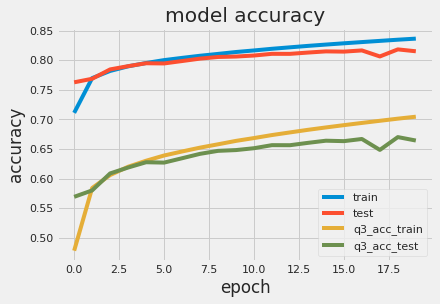

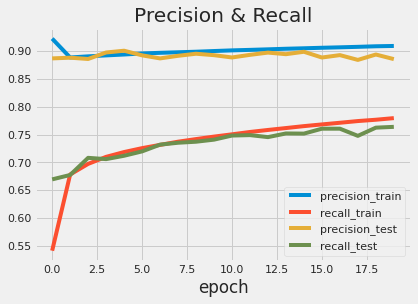

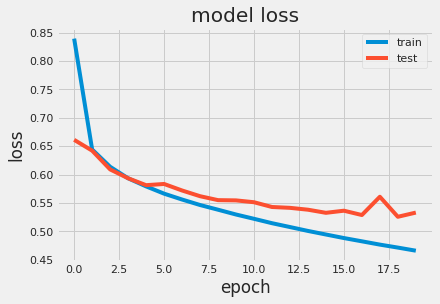

In [ ]:
hist = history.history
metrics = list()
for i in hist.keys():
    metrics.append(i)

# summarize history for accuracy
plt.plot(history.history[metrics[1]])
plt.plot(history.history[metrics[6]])
plt.plot(history.history[metrics[2]])
plt.plot(history.history[metrics[7]])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test','q3_acc_train','q3_acc_test'], loc='best')
plt.show()
# summarize history for precision and recall
plt.plot(history.history[metrics[3]])
plt.plot(history.history[metrics[4]])
plt.plot(history.history[metrics[8]])
plt.plot(history.history[metrics[9]])
plt.title('Precision & Recall')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['precision_train', 'recall_train','precision_test','recall_test'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history.history[metrics[0]])
plt.plot(history.history[metrics[5]])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], )
plt.show()

training
---
Input: MQIGRVRGTVVSSQKEPSMVGVKFLLLQLIDEAGQPLPQYEVAADGVGAGLDEWVLFSRGSAARQVAGSEKRPVDAVVIGIIDTVSVDNRPLYSKKDQYRGSHHHHHH
Target: CEEEEEEEEEEEEEECGGGTTCCEEEEEEECTTCCEEEEEEEEEESSCCCTTCEEEEEEGGGGGGSTTCTTSCCCEEEEEECCEEEETTEEEEECCCCCCCCCCCCCC
Result: CCCCEEEEEEEECCSCCCCCHHHHHEEEEECCTTCCCCEEEEEEEEECSCHHHHEEEHHCCHHHHHCCCSSCCCCEEEEEEECECCCCSCCCCCCCCCCCCCCCCCCC


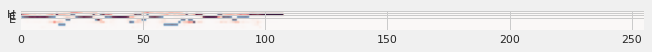

---
Input: MENLIGYVAAFLTTVSFLPAVLRVVMTKQTRDISRNMYIMFFLGVVLWFVYGILRSDLPIILANVVTLFFVTIILYYKLTEGNQTGSLEVLFQ
Target: CHHHHHHHHHHHHHHHTHHHHHHHHSCCTTTTHHHHHHHHHHHHHHHHHHHHHHTTCHHHHHHHHHHHHHHHHHHHHHHHSCSSCCSTHHHHC
Result: CCCHCHHHHHHHHHHHHHHHHHHHHHHHHCHCCCHHHHHHHHHHHHHHHHHHHHHTCHHHHHHHHHHHHHHHHHHHHHHCCCCCCCCCCCCCC


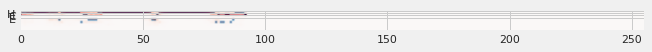

---
Input: QLTESMPFNVAEGKEVLLLVHNLPQQLFGYSWYKGERVDGNRQIVGYAIGTQQATPGPANSGRETIYPNASLLIQNVTQNDTGFYTLQVIKSDLVNEEATGQFHVYGGGGSGGGGSGGGGSGGGGSEVEYRAEVGQNAYLPCFYTPAAPGNLVPVCWGKGACPVFECGNVVLRTDERDVNYWTSRYWLNGDFRKGDVSLTIENVTLADSGIYCCRIQIPGIMNDEKFNLKHHHHHH
Target: CCCCCBTSBCCTTSCEEECCCSCCSSEEEEEEEESSSCCGGGEEEEEETTTTEEEECTTCCSCEEECTTSCEEECSCCGGGCEEEEEEEEETTSCCEEEEEEEBCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCSSCCCCCCCCSCCSSEEEEEEECSSSCCTTTEEEEEETTTTEEEECSSCCSSEEECSSSCEEESSCCSTTCSEEEEEEEETTSCCBCCCEECCCCCC
Result: CCCEEECEECCTTCCEEEEEEECCCCCEEEEEEESSCCTTCEEEEEEEECCEEECECSTCCSCEEECTTCCEEEECCCGGGCCCEEEEEECTSCCCCCCCCCCCEECCCCCCCCCCCCCCCCCCCCCCEEEEEECCCCECCCEECCCCCCCCCEEEEESSSCCSCCCCCEEEECCTSCCCEEECTEEEESCEETTCEEEEEEECCCCTSSEEEEEECCCCCCCCCCCCCCCCCCCC


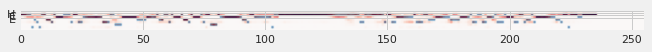

testing
---
Input: PPRFNIANVLLSPDGETFFRGFRSKIHAKGSLVCTGEGDENGVFVVVDGRLRVYLVGEEREISLFYLTSGDMFCMHSGCLVEATERTEVRFADIRTFEQKLQTCPSMAWGLIAILGRALTSCMRTIEDLMHHHHHH
Target: CCCCCTHHHHTSTTTTTTTTTCEEEEECTTCEEECSSCSCCCEEEEEESCEEEEECSTTCCEEEEEECTTCEEESCSSCEEEESSCEEEEEECHHHHHHHHHHCGGGHHHHHHHHHHHHHHHHHHHHHHHCCCCCC
Result: CCCCCCCEEECCTTTCCEEEEEEEEEETTCCEEEECCCCCTEEEEEEETEEEEEEEEEEEEEEEEEEEETCEEECCSTCCCCCCCCCEEEECCTHHHHHHCCCCHHHHHHHHHHHHHHHHHHHCCCCCCCCCCCCC


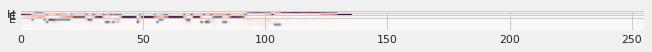

---
Input: AHHHHHHMSPLMVKVLDAVRGSPAINVAVHVFRKAADDTWEPFASGKTSESGELHGLTTEEEFVEGIYKVEIDTKSYWKALGISPFSEHAEVVFTANDSGPRRYTIAALLSPYSYSTTAVVTNPKE
Target: CCCCCCCCCCEEEEEEETTTTEECTTCEEEEEEECTTSCEEEEEEEECCTTSEECCSCCTTTCCSEEEEEEECHHHHHHHHTCCCSEEEEEEEEEECSSSCSEEEEEEEEETTEEEEEEEEECCCC
Result: CCCCCCCCCCEEEEEEETTTTECCTTCEEEEEEECTTSCEEEEEEEECCTTSCECCCCCTTTCCSEEEEEEECHHHHHHHTTCCTSSSEEEEEEEECTTSCCEEEEEEEEETTEEEEEEEEECCCC


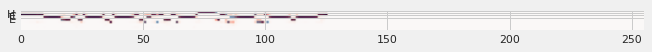

---
Input: CLSYETEILTVEYGLLPIGKIVEKRIECTVYSVDNNGNIYTQPVAQWHDRGEQEVFEYCLEDGSLIRATKDHKFMTVDGQMLPIDEIFERELDLMRVDNLPNLEGHHHHHH
Target: CEETTCEEEETTTEEEEHHHHHHTTCCCEEEEECTTSCEEEEECCEEEEEEEEEEEEEEETTSCEEEECTTCEEEBTTSCEEEHHHHHHTTCBBCBCSCCCCCCCCCCCCC
Result: CCCCCCEEEEHHTTCCHHHHHCCCEEECEEEECCSSSCEEEEEEEEEEEETHHHHHHHHHHTSCCEEEETCCEEEEETSCCCCHHHHHHHHHCCCCCCCCCCCCCCCCCCC


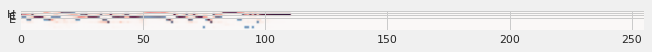

In [ ]:
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

def plot_results(x, y, y_):
    print("---")
    print("Input: " + str(x))
    print("Target: " + str(onehot_to_seq(y, revsere_decoder_index).upper()))
    print("Result: " + str(onehot_to_seq(y_, revsere_decoder_index).upper()))
    fig = plt.figure(figsize=(10,2))
    plt.imshow(y.T, cmap='Blues')
    plt.imshow(y_.T, cmap='Reds', alpha=.5)
    plt.yticks(range(4), [' '] + [revsere_decoder_index[i+1].upper() for i in range(3)])
    plt.show()
    
revsere_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()}
revsere_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()}

N=3
y_train_pred = model.predict(X_train[:N])
y_test_pred = model.predict(X_test[:N])
print('training')
for i in range(N):
    plot_results(seq_train[i], y_train[i], y_train_pred[i])
print('testing')
for i in range(N):
    plot_results(seq_test[i], y_test[i], y_test_pred[i])

## RNN

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_words, output_dim=128, input_length=maxlen_seq),
    tf.keras.layers.SimpleRNN(64,return_sequences=True, recurrent_dropout=0.1),
    tf.keras.layers.Dense(n_tags, activation='softmax'),
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 256, 128)          1077888   
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 256, 64)           12352     
                                                                 
 dense_4 (Dense)             (None, 256, 9)            585       
                                                                 
Total params: 1,090,825
Trainable params: 1,090,825
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy", q8_acc,keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(X_train, y_train, batch_size=256, epochs=20, validation_data=(X_test, y_test), verbose=1)
model.save("/content/drive/MyDrive/Protein/Models/RNNmodel_q8.h5")

Epoch 1/20
132/132 [==============================] - 64s 470ms/step - loss: 0.9098 - accuracy: 0.6666 - q8_acc: 0.4138 - precision_3: 0.9325 - recall_3: 0.5014 - val_loss: 0.7350 - val_accuracy: 0.7313 - val_q8_acc: 0.5125 - val_precision_3: 0.8464 - val_recall_3: 0.6472
Epoch 2/20
132/132 [==============================] - 62s 474ms/step - loss: 0.6947 - accuracy: 0.7497 - q8_acc: 0.5482 - precision_3: 0.8758 - recall_3: 0.6502 - val_loss: 0.6695 - val_accuracy: 0.7597 - val_q8_acc: 0.5639 - val_precision_3: 0.8640 - val_recall_3: 0.6785
Epoch 3/20
132/132 [==============================] - 62s 469ms/step - loss: 0.6663 - accuracy: 0.7608 - q8_acc: 0.5681 - precision_3: 0.8767 - recall_3: 0.6683 - val_loss: 0.6540 - val_accuracy: 0.7651 - val_q8_acc: 0.5738 - val_precision_3: 0.8746 - val_recall_3: 0.6800
Epoch 4/20
132/132 [==============================] - 63s 475ms/step - loss: 0.6509 - accuracy: 0.7668 - q8_acc: 0.5790 - precision_3: 0.8776 - recall_3: 0.6783 - val_loss: 0.6633 -

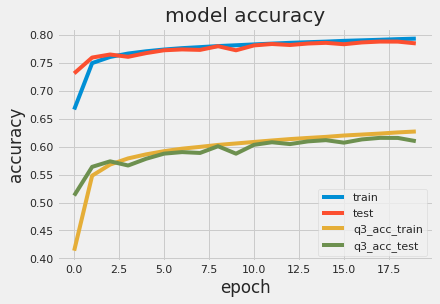

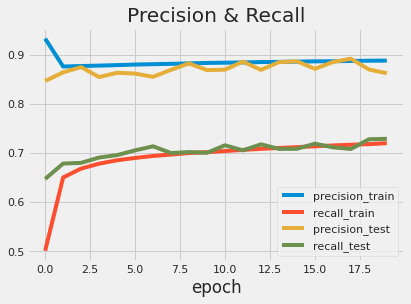

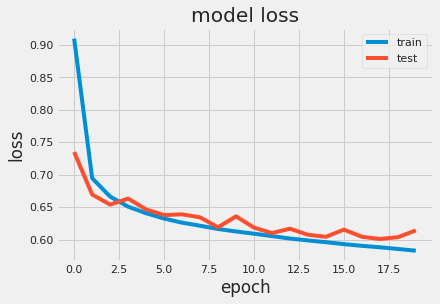

In [ ]:
hist = history.history

metrics = list()
for i in hist.keys():
    metrics.append(i)

# summarize history for accuracy
plt.plot(history.history[metrics[1]])
plt.plot(history.history[metrics[6]])
plt.plot(history.history[metrics[2]])
plt.plot(history.history[metrics[7]])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test','q3_acc_train','q3_acc_test'], loc='best')
plt.show()
# summarize history for precision and recall
plt.plot(history.history[metrics[3]])
plt.plot(history.history[metrics[4]])
plt.plot(history.history[metrics[8]])
plt.plot(history.history[metrics[9]])
plt.title('Precision & Recall')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['precision_train', 'recall_train','precision_test','recall_test'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history.history[metrics[0]])
plt.plot(history.history[metrics[5]])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], )
plt.show()

training
---
Input: MQIGRVRGTVVSSQKEPSMVGVKFLLLQLIDEAGQPLPQYEVAADGVGAGLDEWVLFSRGSAARQVAGSEKRPVDAVVIGIIDTVSVDNRPLYSKKDQYRGSHHHHHH
Target: CEEEEEEEEEEEEEECGGGTTCCEEEEEEECTTCCEEEEEEEEEESSCCCTTCEEEEEEGGGGGGSTTCTTSCCCEEEEEECCEEEETTEEEEECCCCCCCCCCCCCC
Result: CCETEEEEEEEECCCCCCEEEEEEEEEEECCCTTCCCCCEEEEETTCCCTHHHHHHHHHCCHHHHHHCHHCCCHHHHHHEHHHHHHHHCCCCCCCCHHCCCCCCCCCC


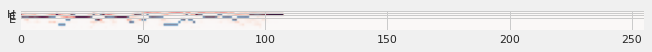

---
Input: MENLIGYVAAFLTTVSFLPAVLRVVMTKQTRDISRNMYIMFFLGVVLWFVYGILRSDLPIILANVVTLFFVTIILYYKLTEGNQTGSLEVLFQ
Target: CHHHHHHHHHHHHHHHTHHHHHHHHSCCTTTTHHHHHHHHHHHHHHHHHHHHHHTTCHHHHHHHHHHHHHHHHHHHHHHHSCSSCCSTHHHHC
Result: CCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHTSCEEHEHHHHHHHHHHHHHHHHHTTCCCCCEHHHCC


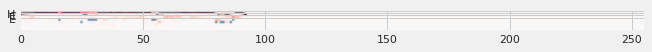

---
Input: QLTESMPFNVAEGKEVLLLVHNLPQQLFGYSWYKGERVDGNRQIVGYAIGTQQATPGPANSGRETIYPNASLLIQNVTQNDTGFYTLQVIKSDLVNEEATGQFHVYGGGGSGGGGSGGGGSGGGGSEVEYRAEVGQNAYLPCFYTPAAPGNLVPVCWGKGACPVFECGNVVLRTDERDVNYWTSRYWLNGDFRKGDVSLTIENVTLADSGIYCCRIQIPGIMNDEKFNLKHHHHHH
Target: CCCCCBTSBCCTTSCEEECCCSCCSSEEEEEEEESSSCCGGGEEEEEETTTTEEEECTTCCSCEEECTTSCEEECSCCGGGCEEEEEEEEETTSCCEEEEEEEBCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCSSCCCCCCCCSCCSSEEEEEEECSSSCCTTTEEEEEETTTTEEEECSSCCSSEEECSSSCEEESSCCSTTCSEEEEEEEETTSCCBCCCEECCCCCC
Result: CCCHCCHEEHHTTCEEEEEEECCCCCEEEEEEEESSCCTTCEEEEEEEEEECECCCCSCCCCCEEECTTCCEEEEEEEECCCEEEEEEEEETTEECEEEEEEEEEECCCCCCCCCCCCCCCCCCCCCCCECECHCHHHHEEEEECCCCTTCCEEEEEECTSCTSEEECEEEEECCSSCCCEESSTEEETTTEEEEEEEEEEEEEEEETTEEEEEEEEETTCCTTTTEEECCCCCCC


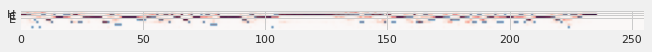

testing
---
Input: PPRFNIANVLLSPDGETFFRGFRSKIHAKGSLVCTGEGDENGVFVVVDGRLRVYLVGEEREISLFYLTSGDMFCMHSGCLVEATERTEVRFADIRTFEQKLQTCPSMAWGLIAILGRALTSCMRTIEDLMHHHHHH
Target: CCCCCTHHHHTSTTTTTTTTTCEEEEECTTCEEECSSCSCCCEEEEEESCEEEEECSTTCCEEEEEECTTCEEESCSSCEEEESSCEEEEEECHHHHHHHHHHCGGGHHHHHHHHHHHHHHHHHHHHHHHCCCCCC
Result: CCCCCCSHEEECTTCCEECHTHHHHHHTTCCEEEECCTCTTTEEEEEETCEEEEEEEEEEEEHHHHHHTTHEEECCCCEEEEEEEHEEEEEHHHHHHHHHHHTCHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCCC


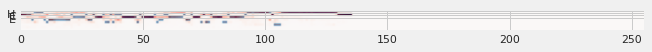

---
Input: AHHHHHHMSPLMVKVLDAVRGSPAINVAVHVFRKAADDTWEPFASGKTSESGELHGLTTEEEFVEGIYKVEIDTKSYWKALGISPFSEHAEVVFTANDSGPRRYTIAALLSPYSYSTTAVVTNPKE
Target: CCCCCCCCCCEEEEEEETTTTEECTTCEEEEEEECTTSCEEEEEEEECCTTSEECCSCCTTTCCSEEEEEEECHHHHHHHHTCCCSEEEEEEEEEECSSSCSEEEEEEEEETTEEEEEEEEECCCC
Result: CCCCCCCCCCEEEEEEETTTTCHCTTEEEEEEEECTTSCEEEEEEEECCTTCEEEESCCTTTCCSEEEEEEECEHHHHHHTTCCTTCHHHEEEEEECTCSCCEEEEEEEEETTEEEEEEEEECCCC


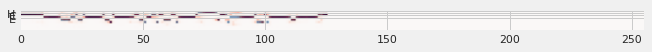

---
Input: CLSYETEILTVEYGLLPIGKIVEKRIECTVYSVDNNGNIYTQPVAQWHDRGEQEVFEYCLEDGSLIRATKDHKFMTVDGQMLPIDEIFERELDLMRVDNLPNLEGHHHHHH
Target: CEETTCEEEETTTEEEEHHHHHHTTCCCEEEEECTTSCEEEEECCEEEEEEEEEEEEEEETTSCEEEECTTCEEEBTTSCEEEHHHHHHTTCBBCBCSCCCCCCCCCCCCC
Result: CCCHHHHHHHHHHHHCCHHEEHHHEEEEEEEEESTTSEEEEEEECEEEEETCEEEEEEEETTSCEEEEETTEEEEEETTEEEEHHHHHHHHHHHHHHHHCHCCCCCCCCCC


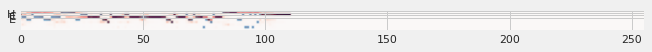

In [ ]:
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

def plot_results(x, y, y_):
    print("---")
    print("Input: " + str(x))
    print("Target: " + str(onehot_to_seq(y, revsere_decoder_index).upper()))
    print("Result: " + str(onehot_to_seq(y_, revsere_decoder_index).upper()))
    fig = plt.figure(figsize=(10,2))
    plt.imshow(y.T, cmap='Blues')
    plt.imshow(y_.T, cmap='Reds', alpha=.5)
    plt.yticks(range(4), [' '] + [revsere_decoder_index[i+1].upper() for i in range(3)])
    plt.show()
    
revsere_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()}
revsere_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()}

N=3
y_train_pred = model.predict(X_train[:N])
y_test_pred = model.predict(X_test[:N])
print('training')
for i in range(N):
    plot_results(seq_train[i], y_train[i], y_train_pred[i])
print('testing')
for i in range(N):
    plot_results(seq_test[i], y_test[i], y_test_pred[i])

## Bi RNN

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_words, output_dim=128, input_length=maxlen_seq),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64,return_sequences=True, recurrent_dropout=0.1)),
    tf.keras.layers.Dense(n_tags, activation='softmax'),
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 256, 128)          1077888   
                                                                 
 bidirectional_2 (Bidirectio  (None, 256, 128)         24704     
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 256, 9)            1161      
                                                                 
Total params: 1,103,753
Trainable params: 1,103,753
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy", q8_acc,keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(X_train, y_train, batch_size=256, epochs=20, validation_data=(X_test, y_test), verbose=1)
model.save("/content/drive/MyDrive/Protein/Models/BiRNNmodel_q8.h5")

Epoch 1/20
132/132 [==============================] - 115s 849ms/step - loss: 0.8579 - accuracy: 0.6830 - q8_acc: 0.4366 - precision_4: 0.9255 - recall_4: 0.5358 - val_loss: 0.6784 - val_accuracy: 0.7565 - val_q8_acc: 0.5582 - val_precision_4: 0.8718 - val_recall_4: 0.6712
Epoch 2/20
132/132 [==============================] - 111s 838ms/step - loss: 0.6387 - accuracy: 0.7723 - q8_acc: 0.5889 - precision_4: 0.8862 - recall_4: 0.6834 - val_loss: 0.6081 - val_accuracy: 0.7842 - val_q8_acc: 0.6085 - val_precision_4: 0.8835 - val_recall_4: 0.7073
Epoch 3/20
132/132 [==============================] - 111s 844ms/step - loss: 0.6054 - accuracy: 0.7856 - q8_acc: 0.6129 - precision_4: 0.8884 - recall_4: 0.7045 - val_loss: 0.5866 - val_accuracy: 0.7929 - val_q8_acc: 0.6242 - val_precision_4: 0.8912 - val_recall_4: 0.7159
Epoch 4/20
132/132 [==============================] - 111s 844ms/step - loss: 0.5873 - accuracy: 0.7929 - q8_acc: 0.6260 - precision_4: 0.8901 - recall_4: 0.7157 - val_loss: 0.60

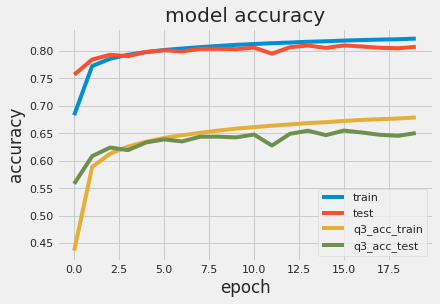

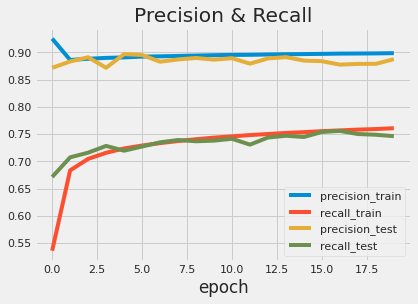

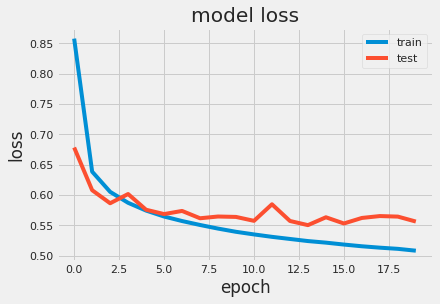

In [ ]:
hist = history.history
metrics = list()
for i in hist.keys():
    metrics.append(i)

# summarize history for accuracy
plt.plot(history.history[metrics[1]])
plt.plot(history.history[metrics[6]])
plt.plot(history.history[metrics[2]])
plt.plot(history.history[metrics[7]])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test','q3_acc_train','q3_acc_test'], loc='best')
plt.show()
# summarize history for precision and recall
plt.plot(history.history[metrics[3]])
plt.plot(history.history[metrics[4]])
plt.plot(history.history[metrics[8]])
plt.plot(history.history[metrics[9]])
plt.title('Precision & Recall')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['precision_train', 'recall_train','precision_test','recall_test'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history.history[metrics[0]])
plt.plot(history.history[metrics[5]])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], )
plt.show()

training
---
Input: MQIGRVRGTVVSSQKEPSMVGVKFLLLQLIDEAGQPLPQYEVAADGVGAGLDEWVLFSRGSAARQVAGSEKRPVDAVVIGIIDTVSVDNRPLYSKKDQYRGSHHHHHH
Target: CEEEEEEEEEEEEEECGGGTTCCEEEEEEECTTCCEEEEEEEEEESSCCCTTCEEEEEEGGGGGGSTTCTTSCCCEEEEEECCEEEETTEEEEECCCCCCCCCCCCCC
Result: CCECEEEEEEEECSCCCCECCCEEEEEEEESTTTSECCEEEEEESSEEETCCEEEEEETTCCCCECCCCSSCCCSEEEEEEEEEEEETCCCCECCCCCCCCCCCCCCC


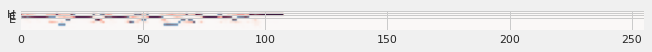

---
Input: MENLIGYVAAFLTTVSFLPAVLRVVMTKQTRDISRNMYIMFFLGVVLWFVYGILRSDLPIILANVVTLFFVTIILYYKLTEGNQTGSLEVLFQ
Target: CHHHHHHHHHHHHHHHTHHHHHHHHSCCTTTTHHHHHHHHHHHHHHHHHHHHHHTTCHHHHHHHHHHHHHHHHHHHHHHHSCSSCCSTHHHHC
Result: CHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHEHHHEEEEEEHHHHGGTTHHHHHHHHHHHHHHHHHHHHHCCTSCCCCCCCCCCC


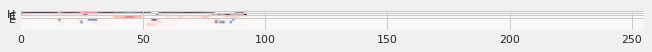

---
Input: QLTESMPFNVAEGKEVLLLVHNLPQQLFGYSWYKGERVDGNRQIVGYAIGTQQATPGPANSGRETIYPNASLLIQNVTQNDTGFYTLQVIKSDLVNEEATGQFHVYGGGGSGGGGSGGGGSGGGGSEVEYRAEVGQNAYLPCFYTPAAPGNLVPVCWGKGACPVFECGNVVLRTDERDVNYWTSRYWLNGDFRKGDVSLTIENVTLADSGIYCCRIQIPGIMNDEKFNLKHHHHHH
Target: CCCCCBTSBCCTTSCEEECCCSCCSSEEEEEEEESSSCCGGGEEEEEETTTTEEEECTTCCSCEEECTTSCEEECSCCGGGCEEEEEEEEETTSCCEEEEEEEBCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCSSCCCCCCCCSCCSSEEEEEEECSSSCCTTTEEEEEETTTTEEEECSSCCSSEEECSSSCEEESSCCSTTCSEEEEEEEETTSCCBCCCEECCCCCC
Result: CCCEEECEEEETTSEEEEEEEECCCSCEEEEEEESSEEETSEEEEEEEETECCCCEEETTCCCEEECTTCEEEEECCCCGCCEEEEEEEEEETECCTCCECEEEEECCCCCCCCCCCCCCCCCCCCCCEEEEEETCCEEECCEECCCCTTCCCCCEECSTTCCCCCCCEEEEEECSSCCTEEESCEEEETCEEETEEEEEEESCCTTTTEEEEEEEEEEECCCCCCCCCCCCCCCC


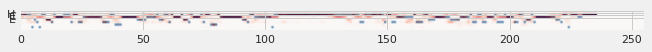

testing
---
Input: PPRFNIANVLLSPDGETFFRGFRSKIHAKGSLVCTGEGDENGVFVVVDGRLRVYLVGEEREISLFYLTSGDMFCMHSGCLVEATERTEVRFADIRTFEQKLQTCPSMAWGLIAILGRALTSCMRTIEDLMHHHHHH
Target: CCCCCTHHHHTSTTTTTTTTTCEEEEECTTCEEECSSCSCCCEEEEEESCEEEEECSTTCCEEEEEECTTCEEESCSSCEEEESSCEEEEEECHHHHHHHHHHCGGGHHHHHHHHHHHHHHHHHHHHHHHCCCCCC
Result: CCEEEEEEEEECTTCCEEEETEEEEEEETEEEEEECEECCTEEEEEEETEEEEEEEESEEEEEEEHHHTTCEEECCCCCEEEEESEEEEEEECCECHSSGCCCCCHHHHHHHHHHHHHHHHHHCCCCCCCCCCCCC


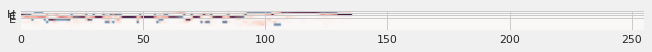

---
Input: AHHHHHHMSPLMVKVLDAVRGSPAINVAVHVFRKAADDTWEPFASGKTSESGELHGLTTEEEFVEGIYKVEIDTKSYWKALGISPFSEHAEVVFTANDSGPRRYTIAALLSPYSYSTTAVVTNPKE
Target: CCCCCCCCCCEEEEEEETTTTEECTTCEEEEEEECTTSCEEEEEEEECCTTSEECCSCCTTTCCSEEEEEEECHHHHHHHHTCCCSEEEEEEEEEECSSSCSEEEEEEEEETTEEEEEEEEECCCC
Result: CCCCCCCCCCEEEEEEETTTTEECTTCEEEEEEECTTSCEEEEEEEECCTTSEECCSCCTTTCCSEEEEEEECHHHHHHHTTCCTTSSEEEEEEEESTTSCCEEEEEEEEETTEEEEEEEEECCCC


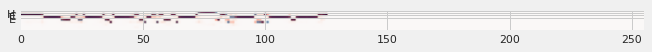

---
Input: CLSYETEILTVEYGLLPIGKIVEKRIECTVYSVDNNGNIYTQPVAQWHDRGEQEVFEYCLEDGSLIRATKDHKFMTVDGQMLPIDEIFERELDLMRVDNLPNLEGHHHHHH
Target: CEETTCEEEETTTEEEEHHHHHHTTCCCEEEEECTTSCEEEEECCEEEEEEEEEEEEEEETTSCEEEECTTCEEEBTTSCEEEHHHHHHTTCBBCBCSCCCCCCCCCCCCC
Result: CCSECEEEEEEETTEEETEEEEEEEEEEEEEEECTTCCEEEECEEEEEEEEEEEEEEEEETTTCEEEEETTEEEEEETTEECCHHHHHHHHCCCCCHHTCCCCCCCCCCCC


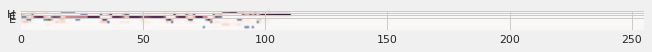

In [ ]:
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

def plot_results(x, y, y_):
    print("---")
    print("Input: " + str(x))
    print("Target: " + str(onehot_to_seq(y, revsere_decoder_index).upper()))
    print("Result: " + str(onehot_to_seq(y_, revsere_decoder_index).upper()))
    fig = plt.figure(figsize=(10,2))
    plt.imshow(y.T, cmap='Blues')
    plt.imshow(y_.T, cmap='Reds', alpha=.5)
    plt.yticks(range(4), [' '] + [revsere_decoder_index[i+1].upper() for i in range(3)])
    plt.show()
    
revsere_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()}
revsere_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()}

N=3
y_train_pred = model.predict(X_train[:N])
y_test_pred = model.predict(X_test[:N])
print('training')
for i in range(N):
    plot_results(seq_train[i], y_train[i], y_train_pred[i])
print('testing')
for i in range(N):
    plot_results(seq_test[i], y_test[i], y_test_pred[i])